# MLOps 워크플로우를 SageMaker로 구현하기



# 0. 질문사항
1. 저는 preprocessing의 결과를 특정 s3 버킷에 넣고 싶은데 자동으로 sagemaker-[region]-[region NUM]-[ACCOUNT NUMBER] 버킷에 들어가는데 어떻게 Manual 버킷으로 옮길 수 있나요?
2. Preprocessing을 수행하는 곳(.py)에 library가 impoart가 안되는데, 설치하려면 어떻게 해야할까요?
3. AWS 서비스에 접근할때, client vs resource 차이점이 무엇인가요?
4. Model Registry할떄 권한 이슈가 나오는데 어떻게 해야할까요?
5. 보내주신 링크를 따라해보았습니다.(Linear Regressor), 실제로 AutoGluon을 사용하기에는 설치해야할 library로 있어 부족함이 있습니다. 1번과 2번이 해결되면 이 문제도 해결될 수 있을것같습니다. 어떻게 해야할까요?

1. 목차
   0. 데이터 추출(Lambda)
        - From Data lake To palm-oil-price-forecast/staged-data
   1. 데이터 전처리(SageMaker Processing)
        - From staged-data to golden-data
        - S3내 데이터읽기 -> raw.csv 합치기 -> 전처리(preprocessing.py) -> golden-data/[yyyy][mm][dd][ts]_processed.csv로 저장
        - 수행 목록 : 원자재데이터(raw.csv) 합치기, Scaling data, Fill missing data
   2. 모델 훈련(SageMaker Train)
       - From golden-data to trained model
       - S3내 데이터읽기 -> AutoGluon 모델링(train.py) -> modeling/yyyymmddts/Model(.h5), Metric(leaderboard) 저장. 
<!--     - 모델 하이퍼파라미터 튜닝(SageMaker의 Automatic Model Tuning) -->
     
   3. 모델검증(SageMaker Processing)
       - From trained-model
       - S3내 leaderboard 읽기 -> Top1 모델 찾기 -> S3내 TOP1 model(.h5) 읽기 -> Inference(inference.py) -> 결과 저장-> Model Registry 등록
   4. 모델배포(QuickSight)
       - From validated-model to LAS VEGAS!!!!
       - 모델검증시 예측값, 실제값 비교 자료
       - Approve시, AWS SageMaker Batch Transform으로 배포
       
2. 데이터: stage-data 내 데이터
   - Date
   - HIGH
   - CLOSE
   - LOW
   - OPEN
   - VOLUME
   - RIC
   
3. 시간소요: ?

4. 질문사항
    - 학습(train) 스크립트를 SageMaker가 아닌 **컨테이너**에서 실행하도록 하고 싶다.
    - 하드코딩이 아니라 SageMaker, Lambda에서 자유자재로 Access Key, Secret Access Key를 꺼내쓰고 싶은데, 보안이 신경쓰인다.
      => Secret Manager
5. 참고한 자료
    - https://github.com/lunarian60/sagemaker-processing/blob/main/scikit_learn_data_processing.ipynb

# 0. 환경구성
- 필요한 패키지 임포트
- 작업 디렉토리 세팅 : local에서 학습과 테스트를 하기 위해)
- SageMaker Session: 다양한 작업을 위해)
- S3 버킷 정의:입출력 데이터 저장
- 버킷: SageMaker가 자동으로 생성하는 디폴트 버킷을 사용할 것입니다. 디폴트 버킷의 이름은 여러분의 Account ID와 리전을 포함하고 있습니다.

In [1]:
import os
import json
import boto3
import pandas as pd
import numpy as np
import base64
from botocore.exceptions import ClientError
from io import StringIO
import time
from botocore.client import Config
from datetime import datetime as dt
import datetime
import glob

from pytz import timezone
from dateutil.relativedelta import *

from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
import sagemaker, boto3, os

from collections import OrderedDict

from matplotlib import pyplot as plt

import copy

In [2]:
def get_list_in_s3(key_id : str,
                secret_key_id : str,
                bucket_name : str,
                s3_path : str) -> list:
    
    s3 = boto3.client('s3',
                      aws_access_key_id = ACCESS_KEY_ID,
                      aws_secret_access_key = ACCESS_SECRET_KEY,
                      region_name = 'ap-northeast-2')
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket = bucket_name,
                               Prefix = s3_path)  # 원하는 bucket 과 하위경로에 있는 object list # dict type
    contents_list = [] # object list의 Contents를 가져옴
    for page in pages:
        for obj in page['Contents']:
            contents_list.append(obj)
    return contents_list

def get_key_in_diclist(diclst : list):
    flist = []
    for dic in diclst:
        key = dic['Key']
        flist.append(key)
    return flist

def download_df_from_S3(key_id : str,
                        secret_key_id : str,
                        bucket_name : str,
                        s3_path : str) -> pd.DataFrame:
    try:
        sesssion = boto3.Session(key_id, secret_key_id)
        s3_resource = sesssion.resource('s3')
        bucket = s3_resource.Bucket(bucket_name)
        findData = bucket.objects.filter(Prefix=s3_path)
        # assert len(list(filter(bool, [obj.key.split('/')[1].split('.')[0] for obj in findData]))) == 1 , '동일한 이름의 파일이 0개 혹은 2개 이상 존재합니다.'
        for obj in bucket.objects.filter(Prefix=s3_path):
            key = obj.key
            if key.split('/')[1] == '': continue
            body = obj.get()['Body']
            csv_string = body.read().decode('utf-8')
            df = pd.read_csv(StringIO(csv_string))
        return df
    except Exception as e:
        return e
    
def upload_df_to_S3(key_id : str,
                    secret_key_id : str,
                    bucket_name : str,
                    s3_path : str,
                    df : pd.DataFrame) -> None:
    try:
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=False)
        s3_resource = boto3.resource(
            's3',
            aws_access_key_id=key_id,
            aws_secret_access_key=secret_key_id,
            config=Config(signature_version='s3v4')
        )
        code = s3_resource.Object(bucket_name, s3_path).put(Body = csv_buffer.getvalue())
        if code['ResponseMetadata']['HTTPStatusCode'] == 200:
            return f'Complete uploading data to {s3_path} in AWS S3'
        else:
            raise Exception('\nHTTPStautsCode is not 200\nPlease See below error message\n'+code)
    except Exception as e:
        return '\n'+e

def get_secret():
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    secret_name = "prod/sagemaker"
    region_name = "ap-northeast-2"
    
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId='prod/sagemaker',
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException': # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException': # An error occurred on the server side.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException': # You provided an invalid value for a parameter.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException': # You provided a parameter value that is not valid for the current state of the resource.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException': # We can't find the resource that you asked for.
            raise e
    else:
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return secret
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return decoded_binary_secret

In [3]:
%%bash
cat /proc/version
cat /proc/meminfo | grep MemTotal
grep -c processor /proc/cpuinfo
# cat /proc/cpuinfo

Linux version 5.10.102-99.473.amzn2.x86_64 (mockbuild@ip-10-0-35-1) (gcc10-gcc (GCC) 10.3.1 20210422 (Red Hat 10.3.1-1), GNU ld version 2.35-21.amzn2.0.1) #1 SMP Wed Mar 2 19:14:12 UTC 2022
MemTotal:       31824204 kB
16


In [4]:
keychain = json.loads(get_secret())
ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
S3_PATH_STAGE = keychain['S3_PATH_STAGE']
S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
S3_PATH_log = keychain['S3_PATH_LOG']

boto3_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)
sm_session = sagemaker.Session(boto_session = boto3_session)
region = boto3_session.region_name

s3_resource = boto3_session.resource('s3')
bucket = s3_resource.Bucket(BUCKET_NAME_USECASE)
s3_client = boto3_session.client('s3')


# 1. SageMaker Processing을 이용한 데이터 전처리(정제)
**워크플로우 요약**
   1. Stage 데이터셋 가지고 오기
   2. First preprocessing: ric 선정 -> 컬럼삭제 -> 형변환 -> 훈련을 위한 dataset로 만들기
   3. SageMaker Processing을 이용한 데이터 전처리   
   4. trainset, testset 나누기
   5. S3 버킷내 golden-data 폴더에 업로드
   6. 학습과 테스트를 위해 레이블 생성 & 저장.
   
**SageMaker Processing?**
- SageMaker 노트북 서버와 분리된 독립적 환경에서 테라바이트 수준의 데이터를 변환처리 가능.   
- 일반적으로 Prototyping 작업에 사용되는 노트북은 SageMaker 일반 사양에서 실행하며 전처리, 학습, 모델 호스팅과 같은 작업은 강력한 사양의 인스턴스에서 실행.    
- SageMaker Processing은 Scikit-learn이 기본 탑재되어 있으며 **Bring Your Own Container** 옵션으로 다양한 데이터 정제 작업을 별도 독립된 환경에서 실행 가능

## 1. Notebook에서 테스트

### (1) Stage Data 폴더 내 데이터들 리스트로 가져오기
- S3 Stage data 버킷 내 데이터들 읽기

In [5]:
dt.today()

datetime.datetime(2022, 11, 5, 4, 23, 21, 331166)

In [6]:
# 폴더 내 파일 리스트 가지고 옴
path_list = []

list_in_stage_dir = get_list_in_s3(ACCESS_KEY_ID,
                                   ACCESS_SECRET_KEY,
                                   BUCKET_NAME_USECASE,
                                   S3_PATH_STAGE)
for dic in list_in_stage_dir:
    key = dic['Key']
    if key[-1] == '/': continue # 만약 폴더형태이면, path 안가지고온다.
    path_list.append(key)
print('데이터수:',len(path_list))
print('마지막 데이터 날짜:',path_list[-1])

데이터수: 12508
마지막 데이터 날짜: staged-data/2022/11/04/1667542531.0/raw.csv


### (2) 추출한 데이터 전처리를 위해 묶기 ** 여기까지 하고 스크립트화로 넘거가기
- golden-data/[yyyy]/[mm]/[dd]/[ts].csv 형태로 저장
- From staged-data To golden-data

In [7]:
%%time
# 파일 리스트로 부터 파일들 가지고 와서 한개의 데이터셋으로 붙이기
start = time.time()

df_raw = pd.DataFrame()
KST = dt.today() + relativedelta(hours=9)
raw_dir = os.path.join(os.getcwd(),'data/raw', KST.strftime('%Y/%m/%d'))

if not os.path.exists(raw_dir): #만약 raw_dir이라는 변수가 선언조차 안되었다 => 오늘날짜의 데이터 추출이 안되었다는 뜻이므로 추출 수행
    for stage_data in path_list: # stage-data 내 데이터들
        df_tmp = download_df_from_S3(ACCESS_KEY_ID,
                                     ACCESS_SECRET_KEY,
                                     BUCKET_NAME_USECASE,
                                     stage_data)
        df_raw = pd.concat([df_raw, df_tmp])
    os.makedirs(raw_dir, exist_ok=True) # 폴더 생성
    df_raw = df_raw.reset_index(drop=True)
    df_raw.to_csv(os.path.join(raw_dir, # 로컬에 하나 저장하자.
                               '{}.csv'.format(int(time.mktime(KST.timetuple())))),
                  index=False)
    
else:
    raw_dir_ts = os.path.join(raw_dir, os.listdir(raw_dir)[0])
    df_raw = pd.read_csv(os.path.join(raw_dir_ts,
                                      '{}.csv'.format(int(time.mktime(KST.timetuple())))))
upload_df_to_S3(ACCESS_KEY_ID,
                ACCESS_SECRET_KEY,
                BUCKET_NAME_USECASE,
                os.path.join(S3_PATH_GOLDEN,
                             KST.strftime('%Y/%m/%d'),
                             '{}.csv'.format('stage')),
                df_raw)
end = time.time()

CPU times: user 19min 19s, sys: 2min 13s, total: 21min 32s
Wall time: 33min 35s


In [8]:
print(f"Staging Data 시간 : {end - start:.1f} sec")
print(f"Staging Data 시간 : {((end - start)/60):.1f} min")

Staging Data 시간 : 2015.7 sec
Staging Data 시간 : 33.6 min


\[2022년 10월 20일 기준\]   
Download and Concat Staging Data 시간 : **2206.9 sec(36.8 min)**

\[2022년 10월 25일 기준\]   
Download and Concat Staging Data 시간 : **2132.1 sec(35.5 min)**

\[2022년 11월 05일 기준\]   
Download and Concat Staging Data 시간 : **2015.7 sec(33.6min)**

---
#### **(별첨)merge를 사용하지 못하는 이유

In [ ]:
test_merge_raw = pd.DataFrame(columns=['Date','HIGH','LOW','OPEN','CLOSE','VOLUME','RIC'])
test_merge_tmp1 = df_tmp
test_merge_tmp2 = df_tmp2

In [ ]:
test_merge_raw

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC


In [ ]:
test_merge_tmp1.head()

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX


In [ ]:
test_merge_tmp2.head()

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-03,23.99,23.72,23.85,23.9200,NaN,BOc1
1,1980-01-03,24.35,24.02,24.15,24.3200,NaN,BOc2
2,1980-01-03,24.65,24.40,24.55,24.6200,NaN,BOc3
3,1980-01-03,NaN,NaN,NaN,1.1703,NaN,CAD=
4,1980-01-03,NaN,NaN,NaN,1.5177,NaN,EUR=


In [ ]:
pd.merge(test_merge_raw,
         test_merge_tmp1, 
         how = 'outer',
         on = 'RIC')

,Date_x,HIGH_x,LOW_x,OPEN_x,CLOSE_x,VOLUME_x,Date_y,HIGH_y,LOW_y,OPEN_y,CLOSE_y,VOLUME_y,RIC
0,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX


In [ ]:
pd.merge(test_merge_raw,
         test_merge_tmp1) 
         # how = 'outer',
         # on = 'RIC')

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC


In [ ]:
pd.concat([test_merge_raw,
           test_merge_tmp1])

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX


** 아래 3)과 4)는 preprocessing으로 처리할 부분이다. 
- 2)까지는 Lambda로 combine staging data하면 되긴 하는데, Sagemaker로 합칠 수 없을까?
- 아래  3), 4)는 preprocessing으로 충분히 할 수 있다.

- 상단의 데이터는 Merge로 했을때의 소요시간과 비교해서 알맞는것으로 설정하자
    => 못쓴다.
- Lambda로 Golden-data로 옮겨주는 작업을 주기적으로 수행하도록 하자.
    => 되나?

In [ ]:
df_raw

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX
2,1980-01-02,23.98,23.63,23.80,23.83,NaN,BOc1
3,1980-01-02,24.35,24.00,24.20,24.13,NaN,BOc2
4,1980-01-02,24.70,24.38,24.65,24.50,NaN,BOc3
...,...,...,...,...,...,...,...
893395,2022-10-24,1402.75,1377.75,1402.75,1381.50,93674.0,Sc2
893396,2022-10-24,1410.00,1386.00,1410.00,1389.25,22126.0,Sc3
893397,2022-10-24,856.50,833.50,853.75,839.50,36624.0,Wc1
893398,2022-10-24,875.75,853.25,873.00,858.25,13915.0,Wc2


**시각화 테스트**

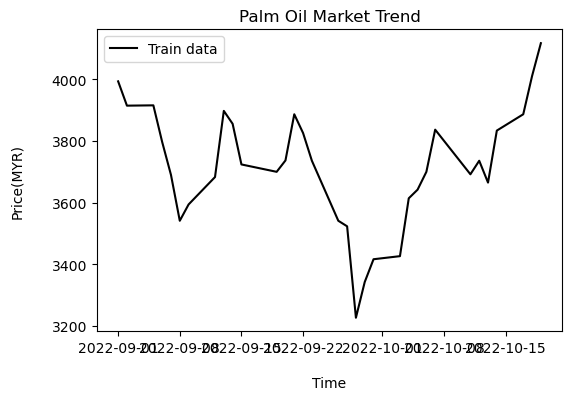

In [ ]:
test = df_raw[df_raw['Date'] > '2022-09'].reset_index(drop=True)
test = test[test['RIC'] == 'FCPOc3']
test.loc[:, "Date"] = pd.to_datetime(test.loc[:, "Date"])
plt.figure(dpi=100)
plt.plot(test['Date'].values,
         test['CLOSE'].values,
         'black', label="Train data")
plt.xlabel('Time', labelpad=15)
plt.ylabel('Price(MYR)', labelpad=20)

plt.title(f'Palm Oil Market Trend')
plt.legend()
plt.show()

### (3) Data cleansing
- EDA에서 선정한 RIC 코드 선별
- 컬럼삭제
- 형변환 
- EDA를 통한 Date별 데이터 선별
- 종합하여 1차 dataset로 만들기

In [ ]:
ric_list_ex01 = ['BOc1', 'BOc2', 'BOc3','BOPLKL','BRRTSc1', 'BRRTSc2', 'BRRTSc3', 'CAD=', 'EUR=', 'JPY=', 'KRW=', 'MYR=', 'GBP=', 'INR=','Cc1', 'Cc2', 'Cc3','CCMc1', 'CCMc2', 'CCMc3',
                 'CLc1', 'CLc2', 'CLc3','CNY=','COMc1', 'COMc2','COMc3','CTc1', 'CTc2', 'CTc3', 'DJCI', 'DJCIBR', 'DJCICL', 'DJCICN', 'DJCIEN', 'DJCIGR', 'DJCIIA', 'DJCING', 
                 'DJCISO', 'DJCIWH', 'DJT','FCHI','FCPOc1', 'FCPOc2', 'FCPOc3','FGVHKL',
                 'FKLIc1', 'FKLIc2', 'FKLIc3','FTSE','GCc1', 'GCc2', 'GCc3','GDAXI','GENMKL','HSI','IOIBKL','IXIC','JNIc1','JNIc2','JNIc3','KCc1', 'KCc2', 'KCc3','KLKKKL','KLSE','KQ11', 'KS11',
                 'KWc1', 'KWc2', 'KWc3','LCOc1', 'LCOc2', 'LCOc3','LWBc1', 'LWBc2', 'LWBc3','MCCc1', 'MCCc2', 'MCCc3','MXSCKL','Oc1', 'Oc2', 'Oc3','PEPTKL','RRc1', 'RRc2', 'RRc3','RSc1', 'RSc2', 'RSc3',
                 'Sc1', 'Sc2', 'Sc3','SIMEKL','SOPSKL','SSEC', 'THPBKL', 'Wc1', 'Wc2', 'Wc3'
                ] #SPX,VIX 더이상 지원안하므로 제거
print('얼마나 데이터 필터링 되었는가?',len(df_raw) - len(df_raw[df_raw['RIC'].isin(ric_list_ex01)]))

In [ ]:
%%time
start = time.time()

data_dir = "raw-data/"

df_list = OrderedDict()
# (1) EDA에서 선정한 RIC 코드 선별
df_tmp1 = df_raw[df_raw['RIC'].isin(ric_list_ex01)]
# (2) 컬럼 삭제
df_tmp1 = df_tmp1[['Date', 'HIGH', 'LOW', 'OPEN', 'CLOSE','RIC']]
# (3) 형 변환
df_tmp1.loc[:, "Date"] = pd.to_datetime(df_tmp1.loc[:, "Date"])
# (4) 종합하여 1차 dataset만들기
for name in ric_list_ex01:
    df_tmp2 = df_tmp1[df_tmp1['RIC'] == name]
    df_tmp2 = df_tmp2.drop('RIC', axis=1)
    df_list[name] = df_tmp2[df_tmp2['Date'] >= '2014-07-02'].reset_index(drop = True)

end = time.time()


In [ ]:
print(f"Dataset화 시간 : {end - start:.1f} sec")
print(f"Dataset화 시간 : {((end - start)/60):.1f} min")

### (4) Fill & Scale data
- 컬럼 일관성 있게 만들기
- Fill missing date
- Apply filling missing value on each columns
- Scaler
- 종합하여 2차 dataset로 만들기

In [53]:
df_col_type = copy.deepcopy(df_list)
col_names = ['ds','high','low','open','y']
for n,x in df_col_type.items():
    df_col_type[n].columns = col_names
    df_col_type[n].loc[:, "ds"] = pd.to_datetime(df_col_type[n].loc[:, "ds"])
    df_col_type[n].loc[:, "high"] = df_col_type[n].loc[:, "high"].astype(np.float32)
    df_col_type[n].loc[:, "low"] = df_col_type[n].loc[:, "low"].astype(np.float32)
    df_col_type[n].loc[:, "open"] = df_col_type[n].loc[:, "open"].astype(np.float32)
    df_col_type[n].loc[:, "y"] = df_col_type[n].loc[:, "y"].astype(np.float32)
    # print(n,'\t', list(x))
    # print('min:', x['ds'].min(), 'max:', x['ds'].max())

In [54]:
def fill_missing_dates(df_in : pd.DataFrame,
                       freq : str
                      ) -> pd.DataFrame : 
    df = df_in.copy()
    if df["ds"].dtype == np.int64:
            df.loc[:, "ds"] = df.loc[:, "ds"].astype(str)
    df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])
    r = pd.date_range(start = df["ds"].min(),
                      end = df["ds"].max(),
                      freq = freq)
    df = df.set_index("ds").reindex(r).rename_axis("ds").reset_index()
    return df

In [55]:
df_fill_date = copy.deepcopy(df_col_type)
for df_one in df_fill_date.items():
    name = df_one[0]
    value = df_one[1]
    # print(name)
    df_fill_date[name]  = fill_missing_dates(value, 'B')
    num_added = len(df_fill_date[name]) - len(value)
    is_na = sum(df_fill_date[name]['y'].isnull())
    # print('num_added:', num_added)
    # print('is_na:',is_na)

In [56]:
def fill_missing_price_value(df: pd.DataFrame, col: str ) -> pd.DataFrame :
    initial_is_na = sum(df[col].isnull())
    series = df.loc[:, col].astype(float)
    series = series.interpolate(method = "linear",
                                limit_direction = "both")
    series = [0 if v < 0 else v for v in series]
    df[col] = series
    # if sum(df[col].isnull()) != 0:
    #     print("is na :", initial_is_na)
    #     print("remaining na :", sum(df[col].isnull()))
    return df

In [57]:
df_list_proc = copy.deepcopy(df_fill_date)
for df_one in df_list_proc.items():
    name = df_one[0]
    value = df_one[1]
    # print(name)
    # print(sum(value['y'].isnull()))
    df_proc1 = fill_missing_price_value(value, 'y')
    df_proc1 = fill_missing_price_value(value, 'high')
    df_proc1 = fill_missing_price_value(value, 'low')
    df_proc1 = fill_missing_price_value(value, 'open')
    # print(sum(df_proc1['y'].isnull()))
    # print(len(df_proc1))
    df_list_proc[name] = df_proc1

**Scaling**

In [58]:
from sklearn.preprocessing import MinMaxScaler
import joblib

In [59]:
import tempfile
def scaling_value(df : pd.DataFrame,
                  col_name : str,
                  ric,
                  s3_resource,
                  BUCKET_NAME_USECASE,
                  S3_PATH_GOLDEN) -> tuple:
    series = df[col_name].values
    scaler = MinMaxScaler()
    series = series.reshape(-1,1)
    scaler.fit(series)
    series = scaler.transform(series)
    with tempfile.TemporaryFile() as fp:
        joblib.dump(scaler, fp)
        fp.seek(0)
        s3_resource.put_object(Body = fp.read(),
                               Bucket = BUCKET_NAME_USECASE,
                               Key = f"{S3_PATH_GOLDEN}/{KST.strftime('%Y/%m/%d')}/scaler-files/{ric}_{col_name}_scaler.pkl")
    return series


**스케일 파일 dump 및 2차 Dataset화**
```python
# READ
with tempfile.TemporaryFile() as fp:
    s3_client.download_fileobj(Fileobj = fp, Bucket = bucket_name, Key = key)
fp.seek(0)
model = joblib.load(fp)
```

In [60]:
%%time
start = time.time()

df_golden = pd.DataFrame()

scale_dir = os.path.join(os.getcwd(), 'preprocessing','scaler-files')
os.makedirs(scale_dir, exist_ok=True)

df_list_scaled = copy.deepcopy(df_list_proc) 

for ric, value in df_list_scaled.items():
    for col in ['y','high','open','low']:
        value.loc[:, col] = scaling_value(value, col, ric, s3_client, BUCKET_NAME_USECASE, S3_PATH_GOLDEN)
    df_list_scaled[name] = value
    
for name, value in df_list_scaled.items():
    value = value.assign(ric = name)
    df_golden = pd.concat([df_golden, value])
df_golden = df_golden.reset_index(drop = True)

upload_df_to_S3(ACCESS_KEY_ID,
                ACCESS_SECRET_KEY,
                BUCKET_NAME_USECASE,
                os.path.join(S3_PATH_GOLDEN,
                             KST.strftime('%Y/%m/%d'),
                             '{}.csv'.format(int(time.mktime(KST.timetuple())))),
                df_golden)

end = time.time()


CPU times: user 3.07 s, sys: 75.8 ms, total: 3.15 s
Wall time: 18.7 s


In [61]:
print(f"Scaling~golden data 업로드 시간 : {end - start:.1f} sec")
print(f"Scaling~golden data 업로드 시간: {((end - start)/60):.1f} min")

Scaling~golden data 업로드 시간 : 18.7 sec
Scaling~golden data 업로드 시간: 0.3 min


## 2. 마지막! 스크립트화 하기!

scikit-learn 전처리 스크립트를 처리 작업으로 실행하려면 제공된 scikit-learn 이미지를 사용하여 처리 작업 내에서 스크립트를 실행할 수 있는 'sklearnProcessor'를 만듭니다.

데이터 정리, 전처리 및 feature 엔지니어링에 사용하는 스크립트를 도입하기 전에 데이터 집합의 처음 20개 행을 검사합니다.


**인풋은 staged-data/2022/10/19/1666160130.0/raw.csv가 될것.**

In [9]:
import pandas as pd

s3_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                   S3_PATH_GOLDEN,
                                   KST.strftime('%Y/%m/%d'),
                                   '{}.csv'.format('stage'),
                                  )
print(s3_uri)
df = pd.read_csv(s3_uri, nrows=10)
df.head(n=10)

s3://palm-oil-price-forecast/golden-data/2022/11/05/stage.csv


,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.3800,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.9400,NaN,SPX
2,1980-01-02,23.98,23.63,23.80,23.8300,NaN,BOc1
3,1980-01-02,24.35,24.00,24.20,24.1300,NaN,BOc2
4,1980-01-02,24.70,24.38,24.65,24.5000,NaN,BOc3
5,1980-01-02,NaN,NaN,NaN,1.1658,NaN,CAD=
6,1980-01-02,NaN,NaN,NaN,1.5149,NaN,EUR=
7,1980-01-02,NaN,NaN,NaN,238.4500,NaN,JPY=
8,1980-01-02,NaN,NaN,NaN,2.1770,NaN,MYR=
9,1980-01-02,NaN,NaN,NaN,2.2331,NaN,GBP=


아래 셀은 전처리 스크립트를 포함하는 `preprocessing.py` 파일을 작성합니다. 
스크립트를 업데이트하고 이 셀을 다시 실행하여 `preprocessing.py`를 덮어 쓸 수 있습니다. 
이 작업은 다음 셀에서 처리 작업으로 실행합니다. 
이 스크립트에서는 아래 기능을 수행합니다.

- Remove duplicates and rows with conflicting data
- transform the target income column into a column containing two labels.
- transform the age and num persons worked for employer numerical columns into categorical features by binning them
- scale the continuous capital gains, capital losses, and dividends from stocks so they're suitable for training
- encode the education, major industry code, class of worker so they're suitable for training
- split the data into training and test datasets, and saves the training features and labels and test features and labels.

In [10]:
%%writefile code/preprocessing.py

import glob
import os
import json
import boto3
import pandas as pd
import numpy as np
import base64
from botocore.exceptions import ClientError
from io import StringIO
import time
from botocore.client import Config
from datetime import datetime as dt
import datetime

from pytz import timezone
from dateutil.relativedelta import *

# import sagemaker
# from sagemaker.debugger import Rule, rule_configs
# from sagemaker.session import TrainingInput
import argparse

from collections import OrderedDict

import copy
from sklearn.preprocessing import MinMaxScaler
import joblib
import tempfile
import sys
import subprocess

ric_list = ['BOc1', 'BOc2', 'BOc3','BOPLKL','BRRTSc1', 'BRRTSc2', 'BRRTSc3', 'CAD=', 'EUR=', 'JPY=', 'KRW=', 'MYR=', 'GBP=', 'INR=','Cc1', 'Cc2', 'Cc3','CCMc1', 'CCMc2', 'CCMc3',
            'CLc1', 'CLc2', 'CLc3','CNY=','COMc1', 'COMc2','COMc3','CTc1', 'CTc2', 'CTc3', 'DJCI', 'DJCIBR', 'DJCICL', 'DJCICN', 'DJCIEN', 'DJCIGR', 'DJCIIA', 'DJCING', 
            'DJCISO', 'DJCIWH', 'DJT','FCHI','FCPOc1', 'FCPOc2', 'FCPOc3','FGVHKL',
            'FKLIc1', 'FKLIc2', 'FKLIc3','FTSE','GCc1', 'GCc2', 'GCc3','GDAXI','GENMKL','HSI','IOIBKL','IXIC','JNIc1','JNIc2','JNIc3','KCc1', 'KCc2', 'KCc3','KLKKKL','KLSE','KQ11', 'KS11',
            'KWc1', 'KWc2', 'KWc3','LCOc1', 'LCOc2', 'LCOc3','LWBc1', 'LWBc2', 'LWBc3','MCCc1', 'MCCc2', 'MCCc3','MXSCKL','Oc1', 'Oc2', 'Oc3','PEPTKL','RRc1', 'RRc2', 'RRc3','RSc1', 'RSc2', 'RSc3',
            'Sc1', 'Sc2', 'Sc3','SIMEKL','SOPSKL','SSEC', 'THPBKL', 'Wc1', 'Wc2', 'Wc3'
           ]
col_names_asis = ['ds','high','low','open','ric']
col_names_tobe = ['ds','high','low','open','y']


def get_secret():
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    secret_name = "prod/sagemaker"
    region_name = "ap-northeast-2"
    
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId='prod/sagemaker',
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException': # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException': # An error occurred on the server side.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException': # You provided an invalid value for a parameter.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException': # You provided a parameter value that is not valid for the current state of the resource.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException': # We can't find the resource that you asked for.
            raise e
    else:
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return secret
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return decoded_binary_secret
        
def fill_missing_dates(df_in : pd.DataFrame,
                       freq : str
                      ) -> pd.DataFrame : 
    df = df_in.copy()
    if df["ds"].dtype == np.int64:
            df.loc[:, "ds"] = df.loc[:, "ds"].astype(str)
    df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])
    r = pd.date_range(start = df["ds"].min(),
                      end = df["ds"].max(),
                      freq = freq)
    df = df.set_index("ds").reindex(r).rename_axis("ds").reset_index()
    return df

def fill_missing_price_value(df: pd.DataFrame, col: str, limit_linear : int = 20 ) -> pd.DataFrame :
    initial_is_na = sum(df[col].isnull())
    series = df.loc[:, col].astype(float)
    series = series.interpolate(method="linear", limit=limit_linear, limit_direction="both")
    series = [0 if v < 0 else v for v in series]
    df[col] = series
    return df

def scaling_value(df : pd.DataFrame,
                  col_name : str,
                  ric,
                  s3_resource,
                  BUCKET_NAME_USECASE,
                  S3_PATH_GOLDEN) -> tuple:
    KST = dt.today() + relativedelta(hours=9)

    series = df[col_name].values
    scaler = MinMaxScaler()
    series = series.reshape(-1,1)
    scaler.fit(series)
    series = scaler.transform(series)
    with tempfile.TemporaryFile() as fp:
        joblib.dump(scaler, fp)
        fp.seek(0)
        s3_resource.put_object(Body = fp.read(),
                               Bucket = BUCKET_NAME_USECASE,
                               Key = f"{S3_PATH_GOLDEN}/{KST.strftime('%Y/%m/%d')}/scaler-files/{ric}_{col_name}_scaler.pkl")
    return series


if __name__=='__main__':

    keychain = json.loads(get_secret())
    ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
    ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

    BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
    S3_PATH_STAGE = keychain['S3_PATH_STAGE']
    S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
    S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
    S3_PATH_log = keychain['S3_PATH_LOG']
    boto_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)

    region = boto_session.region_name

    s3_resource = boto_session.resource('s3')
    parser = argparse.ArgumentParser()
    parser.add_argument("--train_test_split_date",
                        type = str,
                        help = 'train과 test을 구분할 분기점을 설정한다')
    # parser.add_argument("--train_valid_split_date",
    #                     type = str,
    #                     help = 'train과 validation set을 구분할 분기점을 설정한다')

    args, _ = parser.parse_known_args()
    print("Received arguments {}".format(args))

    # 1. 데이터 찾아서 읽기
    f_path_list= []
    for f_path in glob.glob('{}/**/*.csv'.format('/opt/ml/processing/input'), recursive=True):
        print("Reading input data from {}".format(f_path))
        f_path_list.append(f_path)
        
    if len(f_path_list) == 1:
        df_sum = pd.read_csv(f_path_list[0])  # 열 삭제 == 컬럼선별
    else:
        df_sum = pd.DataFrame()
        for file in f_path_list:
            df_tmp = pd.read_csv(file)
            df_sum = pd.concat([df_sum, df_tmp])
    # 2. 첫번쨰 전처리 단계--
    df_list = OrderedDict()
    ## RIC 코드 선별
    df_tmp1 = df_sum[df_sum['RIC'].isin(ric_list)]
    ## 열 삭제 == 컬럼선별
    df_tmp1 = df_tmp1[['Date', 'HIGH', 'LOW', 'OPEN', 'CLOSE','RIC']]
    ## 형변환
    df_tmp1.loc[:, "Date"] = pd.to_datetime(df_tmp1.loc[:, "Date"])
    ## 데이터 셋으로 만들기
    for name in ric_list:
        df_tmp2 = df_tmp1[df_tmp1['RIC'] == name]
        df_tmp2 = df_tmp2.drop('RIC', axis=1)
        df_list[name] = df_tmp2[df_tmp2['Date'] >= '2014-07-02'].reset_index(drop = True)
    # 3. 첫번쨰 전처리 단계--

    col_names = ['ds','high','low','open','y']
    for n,x in df_list.items():
        df_list[n].columns = col_names
        df_list[n].loc[:, "ds"] = pd.to_datetime(df_list[n].loc[:, "ds"])
        df_list[n].loc[:, "high"] = df_list[n].loc[:, "high"].astype(np.float32)
        df_list[n].loc[:, "low"] = df_list[n].loc[:, "low"].astype(np.float32)
        df_list[n].loc[:, "open"] = df_list[n].loc[:, "open"].astype(np.float32)
        df_list[n].loc[:, "y"] = df_list[n].loc[:, "y"].astype(np.float32)

    # 4.
    for df_one in df_list.items():
        name = df_one[0]
        value = df_one[1]
        df_list[name]  = fill_missing_dates(value, 'B')
        num_added = len(df_list[name]) - len(value)
        is_na = sum(df_list[name]['y'].isnull())

    for df_one in df_list.items():
        name = df_one[0]
        value = df_one[1]
        df_proc1 = fill_missing_price_value(value, 'y')
        df_proc1 = fill_missing_price_value(value, 'high')
        df_proc1 = fill_missing_price_value(value, 'low')
        df_proc1 = fill_missing_price_value(value, 'open')
        df_list[name] = df_proc1
    # 5. Scaling
    scale_dir = os.path.join(os.getcwd(), 'preprocessing','scaler-files')
    os.makedirs(scale_dir, exist_ok=True)
    s3_client = boto_session.client('s3')


    for ric, value in df_list.items():
        for col in ['y','high','open','low']:
            value.loc[:, col] = scaling_value(value, col, ric, s3_client, BUCKET_NAME_USECASE, S3_PATH_GOLDEN)
        df_list[name] = value


    df_golden = pd.DataFrame()
    for name, value in df_list.items():
        value = value.assign(ric = name)
        df_golden = pd.concat([df_golden, value])
    df_golden = df_golden.reset_index(drop = True)
    test_split_date = args.train_test_split_date

    df_train = df_golden[df_golden['ds'] < split_date]
    output_train_path = os.path.join('/opt/ml/processing/train', 'train.csv') # 출력파일 저장될 경로 지정
    df_train.to_csv(output_train_path, index = False)
    # validation_split_date = args.train_valid_split_date    
    # df_validation = df_golden[df_golden['ds'] < validation_split_date]
    # output_validation_path = os.path.join('/opt/ml/processing/validaion', 'validation.csv') # 출력파일 저장될 경로 지정
    # df_validation.to_csv(output_validation_path, index = False)
        
    df_test = df_golden[df_golden['ds'] >= split_date]
    output_test_path = os.path.join('/opt/ml/processing/test', 'test.csv') # 출력파일 저장될 경로 지정
    df_test.to_csv(output_test_path, index = False)
    

Overwriting code/preprocessing.py


In [67]:
df_test = df_golden[df_golden['ds'] >= split_date]

NameError: name 'df_test' is not defined

In [126]:
# for f in glob.glob('{}/**/*.csv'.format('/opt/ml/processing/input'), recursive=True):
    # print(f)
for f in glob.glob('{}/**/*.csv'.format('/home/ec2-user/SageMaker/palm-oil-price-forecast'), recursive=True):
    print(f)

/home/ec2-user/SageMaker/palm-oil-price-forecast/data/raw/2022/11/02/1667380163.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/data/raw/2022/10/26/1666766897.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/data/raw/2022/10/20/1666263427.0/raw.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/data/raw/2022/10/31/1667234074.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/data/raw/2022/10/25/1666735766.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/data/golden-data/train/train.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/data/golden-data/test/test.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val02(20140702-20220729)/leaderboard.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val02(20140702-20220729)/prediction.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val04(20140702-20220531)/leaderboard.csv
/home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-

코드실행전 아래는 반드시 살펴보아야 함!
- 'AmazonSageMakerServiceCatalogProductsUseRole'에 해당 리소스를 접근할 권한을 가지고 있는가!
- ex) "arn:aws:s3:::BUCKET_NAME/*"

In [11]:
print('s3://{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                   S3_PATH_GOLDEN,
                                   KST.strftime('%Y/%m/%d'),
                                   ))

s3://palm-oil-price-forecast/golden-data/2022/11/05


In [ ]:

preprocessing_instance_type = "ml.m5.xlarge"
training_instance_type = "ml.m5.xlarge"
inference_instance_type = "ml.m5.xlarge"

In [12]:
%%time
from sagemaker.processing import ProcessingInput, ProcessingOutput
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
import time
start = time.time()

# region = boto_session.region_name
role = get_execution_role()
sklearn_processor = SKLearnProcessor(framework_version = "1.0-1",
                                     role = role,
                                     instance_type = "ml.m5.xlarge",
                                     instance_count = 1
                                    )

s3_source_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                          S3_PATH_GOLDEN,
                                          KST.strftime('%Y/%m/%d'),
                                          '{}.csv'.format('stage'),
                                         )
s3_destination_uri = 's3://{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                            S3_PATH_GOLDEN,
                                            KST.strftime('%Y/%m/%d')
                                           )
sklearn_processor.run(
    code = "preprocessing.py",
    inputs = [
        ProcessingInput(
            source = s3_source_uri,
            input_name = 'stage_data',
            destination = "/opt/ml/processing/input")],
    outputs = [
        ProcessingOutput(
            output_name = "train_data",
            source = "/opt/ml/processing/train",
            destination = s3_destination_uri),
        ProcessingOutput(
            output_name = "test_data",
            source = "/opt/ml/processing/test",
            destination = s3_destination_uri)
    ],
    arguments=["--train_test_split_date", "2022-10-01"],
    # arguments=["--train_valid_split_date", "2022-09-01"],

)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()
end = time.time()


Job Name:  sagemaker-scikit-learn-2022-11-05-04-57-03-872
Inputs:  [{'InputName': 'stage_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05/stage.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-04-57-03-872/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'test_data', 'AppManaged': False, 'S3Output': {'S3

In [13]:
print(f"Staging Data 시간 : {end - start:.1f} sec")
print(f"Staging Data 시간 : {((end - start)/60):.1f} min")

Staging Data 시간 : 282.6 sec
Staging Data 시간 : 4.7 min


\[2022년 11월 05일 기준\]   
Preprocessing 시간 : **282.6 sec(4.7min)**

In [14]:
preprocessing_job_description

{'ProcessingInputs': [{'InputName': 'stage_data',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05/stage.csv',
    'LocalPath': '/opt/ml/processing/input',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-04-57-03-872/input/code/preprocessing.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'train_data',
    'S3Output': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05',
     'LocalPath': '/opt/ml/processing/train',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False},
   {'Outpu

In [15]:
preprocessing_job_description["ProcessingOutputConfig"]

{'Outputs': [{'OutputName': 'train_data',
   'S3Output': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05',
    'LocalPath': '/opt/ml/processing/train',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False},
  {'OutputName': 'test_data',
   'S3Output': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05',
    'LocalPath': '/opt/ml/processing/test',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False}]}

In [16]:
output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]

In [17]:
output_config

{'Outputs': [{'OutputName': 'train_data',
   'S3Output': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05',
    'LocalPath': '/opt/ml/processing/train',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False},
  {'OutputName': 'test_data',
   'S3Output': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/11/05',
    'LocalPath': '/opt/ml/processing/test',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False}]}

# 2. SageMaker Training을 이용한 학습
1. [Autogluon 홈페이지](https://auto.gluon.ai/stable/tutorials/cloud_fit_deploy/cloud-aws-sagemaker-training.html)   
    아쉽다. 이거 쓰고 싶었는데, TabularPredictor만 지원하는거 같아서 패스 [참고](https://github.com/aws/amazon-sagemaker-examples/blob/main/advanced_functionality/autogluon-tabular-containers/ag_model.py)
2. [유동님 링크](https://github.com/lunarian60/sagemaker-processing/blob/main/scikit_learn_data_processing.ipynb) => 1) 참고자료(1)  
    Training using the pre-processed data에서 보면, Sklearn으로 Linear Regressor를 진행하는데, 우리 프로젝트에서는 AutoGluon을 사용하기로 하였다. 우선 Linear Reggressor로 진행을 하고 생각해보자.
3. DeepAR   
    AutoGluon으로 어떻게 할지 감이 잘 안온다. [Time series forecasting with DeepAR - Synthetic data](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.html) 이걸로 감을 잡아보자

## 1) Notebook에서 테스트
우선 제대로 되는지 테스트하자

In [ ]:
# !pip3 install -U pip
# !pip3 install -U setuptools wheel

# # CPU version of pytorch has smaller footprint - see installation instructions in
# # pytorch documentation - https://pytorch.org/get-started/locally/
# !pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

!pip install autogluon --user

In [ ]:
!pip install mxnet==1.9 --user

In [160]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd

In [40]:
# 2. 최하단에 처리됬던 부분 확인용
print(preprocessed_training_data)
print(preprocessed_test_data)
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

s3://palm-oil-price-forecast/golden-data/2022/10/31
s3://palm-oil-price-forecast/golden-data/2022/10/31
AWS Region: ap-northeast-2
RoleArn: arn:aws:iam::276114397529:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


### (1) 데이터 불러오고 AutoGluon TimeSeries로 만들어주기

In [158]:
df_train= pd.read_csv(os.path.join(preprocessed_training_data,
                                   'train.csv'))
df_train.head()

,ds,high,low,open,y,ric
0,2014-07-02,0.208453,0.214707,0.211996,0.205457,BOc1
1,2014-07-03,0.203925,0.212535,0.205891,0.206828,BOc1
2,2014-07-04,0.202868,0.210673,0.206273,0.205304,BOc1
3,2014-07-07,0.201811,0.208812,0.206654,0.203780,BOc1
4,2014-07-08,0.200151,0.203692,0.204976,0.195245,BOc1


`ImportError: Install s3fs to access S3` => !pip install s3fs --upgrade


In [157]:
df_test = pd.read_csv(os.path.join(preprocessed_test_data,
                                   'test.csv'))
df_test.head()

,ds,high,low,open,y,ric
0,2022-10-03,0.630642,0.633881,0.618437,0.638470,BOc1
1,2022-10-04,0.654792,0.677319,0.662088,0.665142,BOc1
2,2022-10-05,0.657057,0.659479,0.666819,0.671087,BOc1
3,2022-10-06,0.664906,0.668942,0.667277,0.680994,BOc1
4,2022-10-07,0.683774,0.710673,0.693987,0.687243,BOc1


In [161]:
df_train.loc[:, "ds"] = pd.to_datetime(df_train.loc[:, "ds"])
df_test.loc[:, "ds"] = pd.to_datetime(df_test.loc[:, "ds"])
train_data = TimeSeriesDataFrame.from_data_frame(
    df_train,
    id_column="ric",
    timestamp_column="ds",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="ric",
    timestamp_column="ds",
)


                        high       low      open         y
item_id timestamp                                         
BOc1    2014-07-02  0.208453  0.214707  0.211996  0.205457
        2014-07-03  0.203925  0.212535  0.205891  0.206828
        2014-07-04  0.202868  0.210673  0.206273  0.205304
        2014-07-07  0.201811  0.208812  0.206654  0.203780
        2014-07-08  0.200151  0.203692  0.204976  0.195245


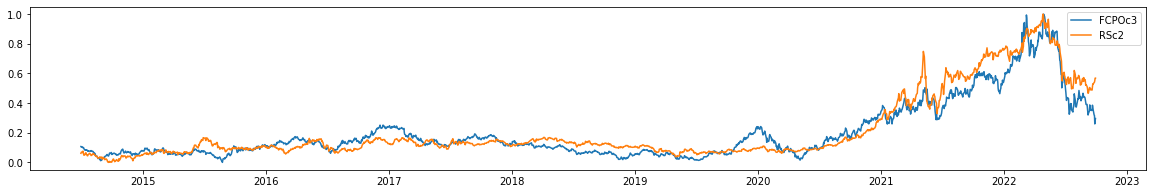

In [45]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df_train,
    id_column="ric",
    timestamp_column="ds",
)

plt.figure(figsize=(20, 3))
print(train_data.head())
for ric in ["FCPOc3", "RSc2"]:
    plt.plot(train_data.loc[ric]['y'], label=ric)
plt.legend()

                        high       low      open         y
item_id timestamp                                         
BOc1    2022-10-03  0.630642  0.633881  0.618437  0.638470
        2022-10-04  0.654792  0.677319  0.662088  0.665142
        2022-10-05  0.657057  0.659479  0.666819  0.671087
        2022-10-06  0.664906  0.668942  0.667277  0.680994
        2022-10-07  0.683774  0.710673  0.693987  0.687243


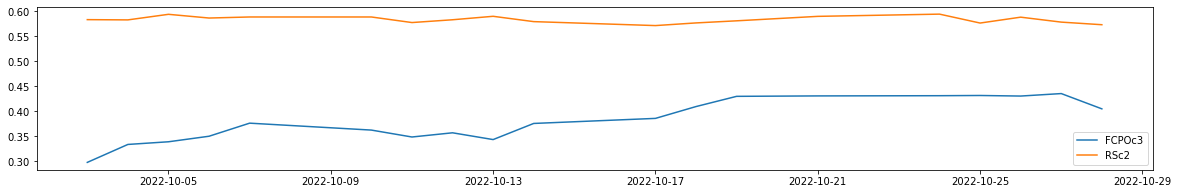

In [46]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="ric",
    timestamp_column="ds",
)

plt.figure(figsize=(20, 3))
print(test_data.head())
for ric in ["FCPOc3", "RSc2"]:
    plt.plot(test_data.loc[ric]['y'], label=ric)
plt.legend()

In [120]:
print(train_data.loc["FCPOc3"]["y"].index.min(), '~', train_data.loc["FCPOc3"]["y"].index.max())

2014-07-02 00:00:00 ~ 2022-09-30 00:00:00


### (2) 모델 검증을 위한 step별로 밟기 위한 데이터 셋 나누기

아직 Dev버전에서만 작동중
```python

from autogluon.timeseries.spitter import MultiWindowSplitter

splitter = MultiWindowSplitter(num_windows=23)
# _, test_data_multi_window = splitter.split(train_data, prediction_length)

predictor = TimeSeriesPredictor(validation_splitter=splitter,
                                eval_metric="MAPE")
predictor.fit(train_data=train_data)


predictor.evaluate(test_data_multi_window)
```

In [52]:
train_data = train_data.sort_index(ascending=True)#이거 안해주면 UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [1], lexsort depth 0'

train_data_01, test_data_01 = train_data.split_by_time(pd.Timestamp(2022,9,1))
train_data_02, test_data_02 = train_data_01.split_by_time(pd.Timestamp(2022,8,1))
train_data_03, test_data_03 = train_data_02.split_by_time(pd.Timestamp(2022,7,1))
train_data_04, test_data_04 = train_data_03.split_by_time(pd.Timestamp(2022,6,1))
train_data_05, test_data_05 = train_data_04.split_by_time(pd.Timestamp(2022,5,1))


In [53]:
print('Validation dataset Sep')
print('Train:\t',train_data_01.loc["FCPOc3"]["y"].index.min(),'~',train_data_01.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_01.loc["FCPOc3"]["y"].index.min(),'~',test_data_01.loc["FCPOc3"]["y"].index.max())
print('Validation dataset Aug')
print('Train:\t',train_data_02.loc["FCPOc3"]["y"].index.min(),'~',train_data_02.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_02.loc["FCPOc3"]["y"].index.min(),'~',test_data_02.loc["FCPOc3"]["y"].index.max())
print('Validation dataset Jul')
print('Train:\t',train_data_03.loc["FCPOc3"]["y"].index.min(),'~',train_data_03.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_03.loc["FCPOc3"]["y"].index.min(),'~',test_data_03.loc["FCPOc3"]["y"].index.max())
print('Validation dataset Jun')
print('Train:\t',train_data_04.loc["FCPOc3"]["y"].index.min(),'~',train_data_04.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_04.loc["FCPOc3"]["y"].index.min(),'~',test_data_04.loc["FCPOc3"]["y"].index.max())
print('Validation dataset May')
print('Train:\t',train_data_05.loc["FCPOc3"]["y"].index.min(),'~',train_data_05.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_05.loc["FCPOc3"]["y"].index.min(),'~',test_data_05.loc["FCPOc3"]["y"].index.max())


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-08-31 00:00:00
Test:	 2022-09-01 00:00:00 ~ 2022-09-30 00:00:00
Validation dataset Aug
Train:	 2014-07-02 00:00:00 ~ 2022-07-29 00:00:00
Test:	 2022-08-01 00:00:00 ~ 2022-08-31 00:00:00
Validation dataset Jul
Train:	 2014-07-02 00:00:00 ~ 2022-06-30 00:00:00
Test:	 2022-07-01 00:00:00 ~ 2022-07-29 00:00:00
Validation dataset Jun
Train:	 2014-07-02 00:00:00 ~ 2022-05-31 00:00:00
Test:	 2022-06-01 00:00:00 ~ 2022-06-30 00:00:00
Validation dataset May
Train:	 2014-07-02 00:00:00 ~ 2022-04-29 00:00:00
Test:	 2022-05-02 00:00:00 ~ 2022-05-31 00:00:00


### (3) Model training for each data set

In [54]:
print('Validation dataset Sep')
print('Train:\t',train_data_01.loc["FCPOc3"]["y"].index.min(),'~',train_data_01.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_01.loc["FCPOc3"]["y"].index.min(),'~',test_data_01.loc["FCPOc3"]["y"].index.max())

Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-08-31 00:00:00
Test:	 2022-09-01 00:00:00 ~ 2022-09-30 00:00:00


In [60]:
print('testdata01 갯수:',len(test_data_01.loc["FCPOc3"]["y"]))
print('testdata02 갯수:',len(test_data_02.loc["FCPOc3"]["y"]))

testdata01 갯수: 22
testdata02 갯수: 23


In [58]:
val01_model_path = "model/autogluon-FCPOc3-t1-val01({}-{})".format(train_data_01.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_01.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
val01_model_path

'model/autogluon-FCPOc3-t1-val01(20140702-20220831)'

In [61]:
%%time
predictor_val01 = TimeSeriesPredictor(
    path = val01_model_path,
    target ='y',
    prediction_length = len(test_data_02.loc["FCPOc3"]["y"]),
    eval_metric = "MAPE",
)
predictor_val01.fit(
    train_data=train_data_01,
    presets="low_quality"
)

presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 23,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 215166 rows, 101 items. Average time series length is 2130.3564356435645.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val01(20140702-20220831)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 23 time steps out to use as validation set.

Starting training. Start time is 2022-10-31 22:02:56
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'ARIMA', 'Transformer']
Training timeseries model AutoETS. 
	-0.0734       = Validation score (-MAPE)
	18.60   s     = Training r

CPU times: user 4min 38s, sys: 1.28 s, total: 4min 39s
Wall time: 2min 54s


In [62]:
%%time
predictor_val01_lb = predictor_val01.leaderboard(test_data_01, silent=True)
predictor_val01_lb.to_csv(os.path.join(os.getcwd(),val01_model_path,'leaderboard.csv'))

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS. An error occurred: division by zero
Cannot score with model SimpleFeedForward. An error occurred: division by zero
Cannot score with model DeepAR. An error occurred: division by zero
Cannot score with model ARIMA. An error occurred: division by zero
Cannot score with model Transformer. An error occurred: division by zero
Cannot score with model WeightedEnsemble. An error occurred: division by zero


CPU times: user 1.53 s, sys: 51.9 ms, total: 1.58 s
Wall time: 1.57 s


In [67]:
%%time
predictions_val01_model01 = predictor_val01.predict(data = train_data_01,
                                                    model = predictor_val01_lb['model'][0])

Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


CPU times: user 1min 34s, sys: 298 ms, total: 1min 34s
Wall time: 1min 17s


In [68]:
predictions_val01_model01.loc['FCPOc3']['mean']

timestamp
2022-09-01    0.427175
2022-09-02    0.430997
2022-09-05    0.424519
2022-09-06    0.428840
2022-09-07    0.427595
2022-09-08    0.433288
2022-09-09    0.428349
2022-09-12    0.424399
2022-09-13    0.425742
2022-09-14    0.434358
2022-09-15    0.429544
2022-09-16    0.435424
2022-09-19    0.432415
2022-09-20    0.437482
2022-09-21    0.428005
2022-09-22    0.436592
2022-09-23    0.430048
2022-09-26    0.432262
2022-09-27    0.430580
2022-09-28    0.427609
2022-09-29    0.429873
2022-09-30    0.430283
2022-10-03    0.425888
Name: mean, dtype: float64

In [76]:
val01_result = pd.merge(test_data_01.loc['FCPOc3']['y'],  predictions_val01_model01.loc['FCPOc3'][['mean','0.9','0.1']], 
                        left_index=True, right_index=True, 
                        how='left')

In [77]:
val01_result

,y,mean,0.9,0.1
timestamp,,,,
2022-09-01,0.406149,0.427175,0.474660,0.380838
2022-09-02,0.391064,0.430997,0.475929,0.386214
2022-09-05,0.391255,0.424519,0.481321,0.368118
2022-09-06,0.368532,0.428840,0.478973,0.369992
2022-09-07,0.348100,0.427595,0.490973,0.368011
2022-09-08,0.319649,0.433288,0.495923,0.367351
2022-09-09,0.329769,0.428349,0.489991,0.368320
2022-09-12,0.346763,0.424399,0.487585,0.358189
2022-09-13,0.387817,0.425742,0.493634,0.355634


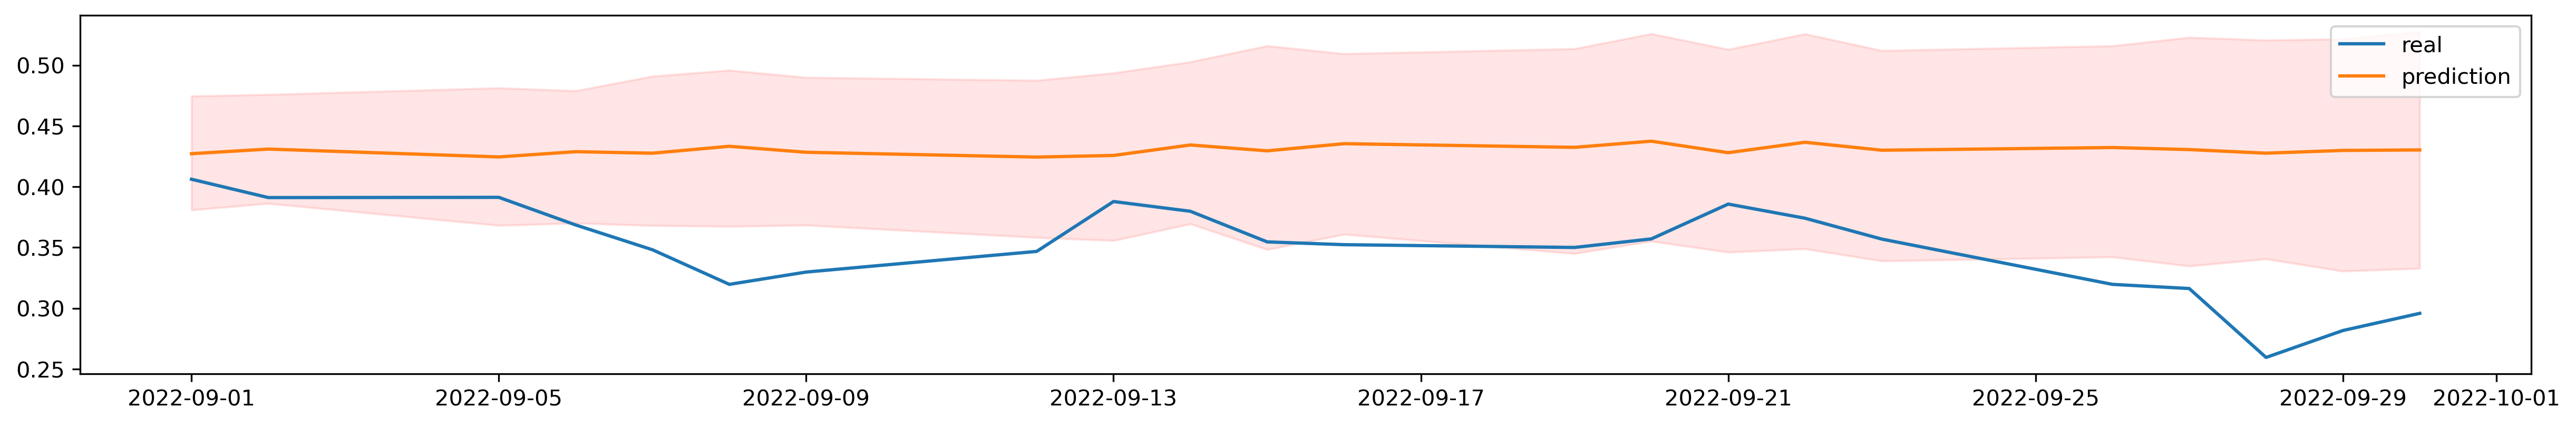

In [78]:
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val01_result['y'], label='real')
plt.plot(val01_result['mean'], label='prediction')

plt.fill_between(
    val01_result.index, val01_result["0.1"], val01_result["0.9"], color="red", alpha=0.1
)
plt.legend()

In [222]:
val01_result.to_csv(os.path.join(os.getcwd(),val01_model_path,'prediction.csv'))

In [223]:
import os
from tqdm import tqdm

def upload_folder_to_s3(s3_client, s3bucket, input_dir, s3_path):
    pbar = tqdm(os.walk(input_dir))
    for path, subdirs, files in pbar:
        for file in files:
            dest_path = path.replace(input_dir, "").replace(os.sep, '/')
            s3_file = f'{s3_path}/{dest_path}/{file}'.replace('//', '/')
            local_file = os.path.join(path, file)
            s3_client.upload_file(local_file, s3bucket, s3_file)
            pbar.set_description(f'Uploaded {local_file} to {s3_file}')
    print(f"Successfully uploaded {input_dir} to S3 {s3_path}")
    
s3_client = boto3.client('s3', aws_access_key_id=ACCESS_KEY_ID, aws_secret_access_key=ACCESS_SECRET_KEY)
upload_folder_to_s3(s3_client, BUCKET_NAME_USECASE, os.path.join(os.getcwd(),'model'), S3_PATH_TRAIN)

Uploaded /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val01(20140702-20220812)/utils/data/val.pkl to trained-model/autogluon-FCPOc3-t1-val01(20140702-20220812)/utils/data/val.pkl: : 25it [00:05,  4.85it/s]                                                                                      

Successfully uploaded /home/ec2-user/SageMaker/palm-oil-price-forecast/model to S3 trained-model


In [79]:
predictor_val01_lb

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,NaN,-0.068014,NaN,22.711291,55.606254,6
1,Transformer,NaN,-0.076772,NaN,2.237203,5.864951,5
2,SimpleFeedForward,NaN,-0.074817,NaN,0.609012,3.472084,2
3,DeepAR,NaN,-0.078808,NaN,1.250058,8.306346,3
4,AutoETS,NaN,-0.073402,NaN,7.688082,18.600846,1
5,ARIMA,NaN,-0.089269,NaN,10.926936,35.656236,4


---
Summary

---

Learner random seed set to 0
presets is set to high_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: high_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 10,
                                'scheduler': 'local',
                                'searcher': 'random'},
 'hyperparameters': 'default_hpo',
 'prediction_length': 30,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 215166 rows, 101 items. Average time series length is 2130.3564356435645.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val01(20140702-20220831)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 30 time steps out to use as validation set.


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-08-31 00:00:00
Test:	 2022-09-01 00:00:00 ~ 2022-09-30 00:00:00
22
model/autogluon-FCPOc3-t1-val01(20140702-20220831)


AutoGluon will save models to model/autogluon-FCPOc3-t1-val01(20140702-20220831)/

Starting training. Start time is 2022-10-27 15:58:35
Models that will be trained: ['AutoETS', 'DeepAR', 'SimpleFeedForward', 'ARIMA', 'Transformer']
Hyperparameter tuning model: AutoETS. 


  0%|          | 0/10 [00:00<?, ?it/s]

endog must be strictly positive when usingmultiplicative error, trend or seasonal components.
Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 45, in model_trial
    time_limit=time_limit,
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 73, in fit_and_save_model
    train_data=train_data, val_data=val_data, time_limit=time_left, **fit_kwargs
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 188, in fit
    return super().fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 587, in fit
    out = self._fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/sktime/abstract_sktime.py", line 140, in _fit
    self._to_skt_dat

  0%|          | 0/10 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 10 models while tuning DeepAR.
	-0.0916       = Validation score (-MAPE)
	7483.13 s     = Total tuning time
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/10 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).


Stopping HPO due to exhausted search space: 2 of 2 possible configs ran.
	Trained 2 models while tuning SimpleFeedForward.
	-0.0915       = Validation score (-MAPE)
	232.29  s     = Total tuning time
Hyperparameter tuning model: ARIMA. 


  0%|          | 0/10 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 1 of 1 possible configs ran.
	Trained 1 models while tuning ARIMA.
	-0.0932       = Validation score (-MAPE)
	64.91   s     = Total tuning time
Hyperparameter tuning model: Transformer. 


  0%|          | 0/10 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


Stopping HPO due to exhausted search space: 3 of 3 possible configs ran.
	Trained 3 models while tuning Transformer.
	-0.0964       = Validation score (-MAPE)
	795.85  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.0855       = Validation score (-MAPE)
	192.05  s     = Training runtime
	31.08   s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS/T1', 'DeepAR/T1', 'DeepAR/T2', 'DeepAR/T3', 'DeepAR/T4', 'DeepAR/T5', 'DeepAR/T6', 'DeepAR/T7', 'DeepAR/T8', 'DeepAR/T9', 'DeepAR/T10', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'ARIMA/T1', 'Transformer/T1', 'Transformer/T2', 'Transformer/T3', 'WeightedEnsemble']
Total runtime: 8866.92 s
Best model: WeightedEnsemble
Best model score: -0.0855
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS/T1. An error occurred: division by zero
Cannot score with model DeepAR/T1. An error occur

CPU times: user 16h 9min, sys: 4min 29s, total: 16h 13min 30s
Wall time: 2h 29min 10s


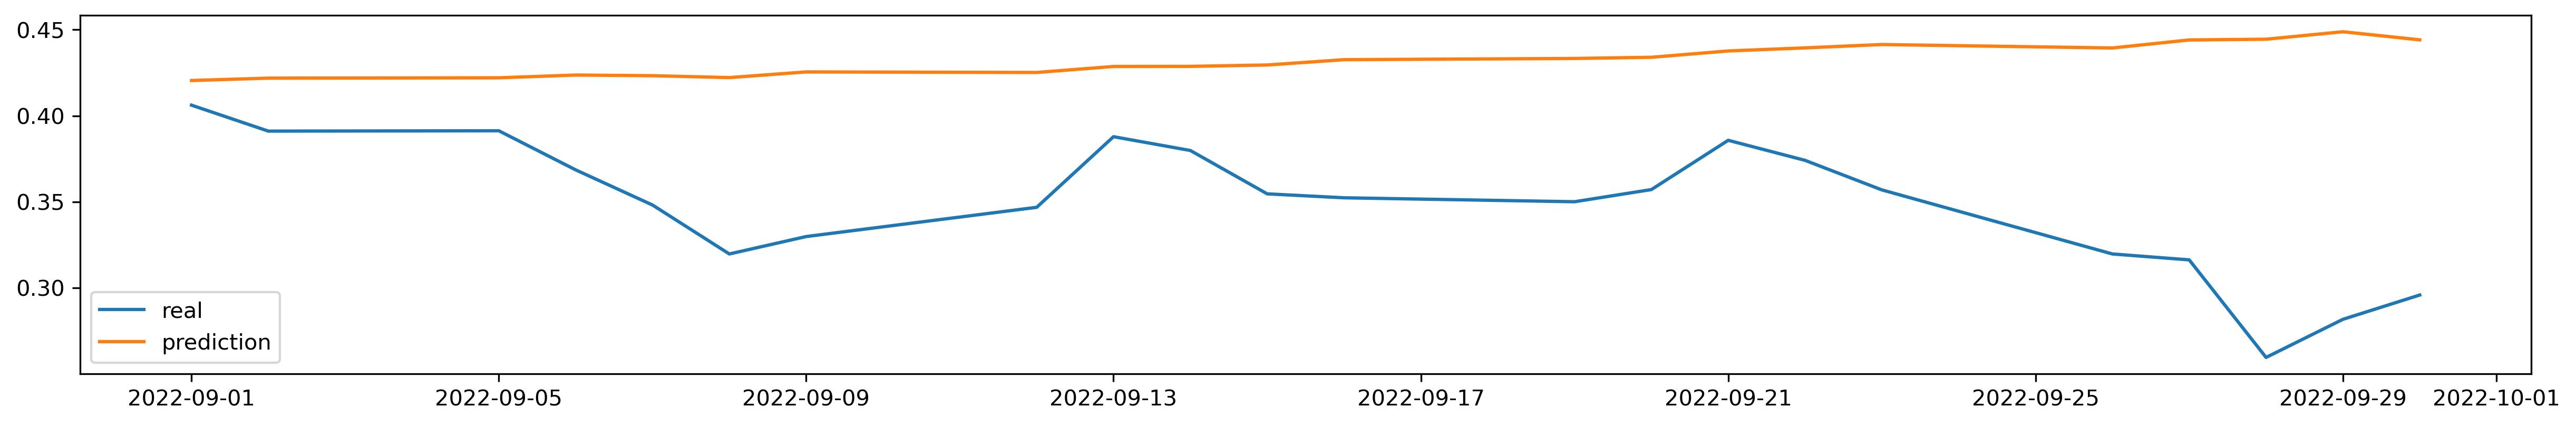

In [237]:
%%time
start = time.time()

print('Validation dataset September')
print('Train:\t',train_data_01.loc["FCPOc3"]["y"].index.min(),'~',train_data_01.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_01.loc["FCPOc3"]["y"].index.min(),'~',test_data_01.loc["FCPOc3"]["y"].index.max())
print(len(test_data_01.loc["FCPOc3"]["y"]))

val01_model_path = "model/autogluon-FCPOc3-t1-val01({}-{})".format(train_data_01.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_01.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
prediction_length = 30

print(val01_model_path)

predictor_val01 = TimeSeriesPredictor(
    path = val01_model_path,
    target ='y',
    prediction_length = prediction_length,
    eval_metric = "MAPE",
)
predictor_val01.fit(
    train_data=train_data_01,
    presets="high_quality"
)

predictor_val01_lb = predictor_val01.leaderboard(test_data_01, silent=True)
predictor_val01_lb.to_csv(os.path.join(os.getcwd(),
                                       val01_model_path,
                                       'leaderboard.csv')
                         )

predictions_val01_model01 = predictor_val01.predict(data = train_data_01,
                                                model = predictor_val01_lb['model'][0])

val01_result = pd.merge(test_data_01.loc['FCPOc3']['y'],  predictions_val01_model01.loc['FCPOc3']['mean'], 
                        left_index=True, right_index=True, 
                        how='left')
    
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val01_result['y'], label='real')
plt.plot(val01_result['mean'], label='prediction')
plt.legend()

val01_result.to_csv(os.path.join(os.getcwd(),val01_model_path,'prediction.csv'))

end = time.time()

In [238]:
print(f"high_quality시간 : {end - start:.1f} sec")
print(f"high_quality 시간: {((end - start)/60):.1f} min")

high_quality시간 : 8950.4 sec
high_quality 시간: 149.2 min


**val02: August**

Learner random seed set to 0
presets is set to good_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: good_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 2,
                                'scheduler': 'local',
                                'searcher': 'random'},
 'hyperparameters': 'default_hpo',
 'prediction_length': 30,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 212843 rows, 101 items. Average time series length is 2107.3564356435645.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val02(20140702-20220729)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 30 time steps out to use as validation set.


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-07-29 00:00:00
Test:	 2022-08-01 00:00:00 ~ 2022-08-31 00:00:00
23
model/autogluon-FCPOc3-t1-val02(20140702-20220729)


AutoGluon will save models to model/autogluon-FCPOc3-t1-val02(20140702-20220729)/

Starting training. Start time is 2022-10-27 18:27:46
Models that will be trained: ['AutoETS', 'DeepAR', 'SimpleFeedForward', 'ARIMA', 'Transformer']
Hyperparameter tuning model: AutoETS. 


  0%|          | 0/2 [00:00<?, ?it/s]

endog must be strictly positive when usingmultiplicative error, trend or seasonal components.
Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 45, in model_trial
    time_limit=time_limit,
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 73, in fit_and_save_model
    train_data=train_data, val_data=val_data, time_limit=time_left, **fit_kwargs
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 188, in fit
    return super().fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 587, in fit
    out = self._fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/sktime/abstract_sktime.py", line 140, in _fit
    self._to_skt_dat

  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning DeepAR.
	-0.2192       = Validation score (-MAPE)
	1139.50 s     = Total tuning time
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning SimpleFeedForward.
	-0.1551       = Validation score (-MAPE)
	221.57  s     = Total tuning time
Hyperparameter tuning model: ARIMA. 


  0%|          | 0/2 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 1 of 1 possible configs ran.
	Trained 1 models while tuning ARIMA.
	-0.2112       = Validation score (-MAPE)
	64.88   s     = Total tuning time
Hyperparameter tuning model: Transformer. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning Transformer.
	-0.1944       = Validation score (-MAPE)
	465.58  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.1549       = Validation score (-MAPE)
	92.30   s     = Training runtime
	3.27    s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS/T1', 'DeepAR/T1', 'DeepAR/T2', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'ARIMA/T1', 'Transformer/T1', 'Transformer/T2', 'WeightedEnsemble']
Total runtime: 2056.80 s
Best model: WeightedEnsemble
Best model score: -0.1549
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS/T1. An error occurred: division by zero
Cannot score with model DeepAR/T1. An error occurred: division by zero
Cannot score with model DeepAR/T2. An error occurred: division by zero
Cannot score with model SimpleFeedForward/T1. An error occurred: division by zero
Cannot score with mod

CPU times: user 3h 14min 20s, sys: 1min 1s, total: 3h 15min 21s
Wall time: 34min 21s


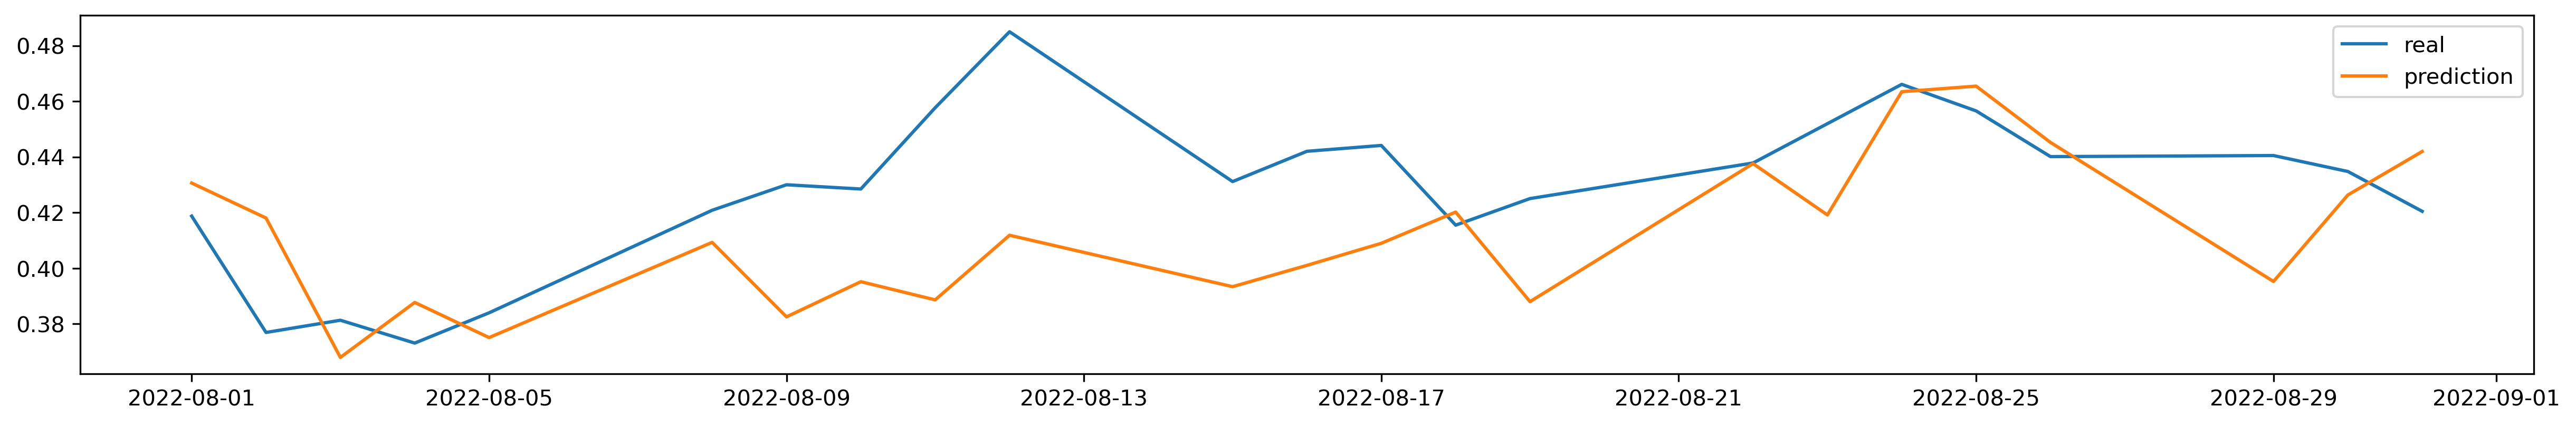

In [239]:
%%time
start = time.time()
 
print('Validation dataset August')
print('Train:\t',train_data_02.loc["FCPOc3"]["y"].index.min(),'~',train_data_02.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_02.loc["FCPOc3"]["y"].index.min(),'~',test_data_02.loc["FCPOc3"]["y"].index.max())
print(len(test_data_02.loc["FCPOc3"]["y"]))

val02_model_path = "model/autogluon-FCPOc3-t1-val02({}-{})".format(train_data_02.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_02.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
prediction_length = 30

print(val02_model_path)

predictor_val02 = TimeSeriesPredictor(
    path = val02_model_path,
    target ='y',
    prediction_length = prediction_length,
    eval_metric = "MAPE",
)
predictor_val02.fit(
    train_data=train_data_02,
    presets="good_quality"
)

predictor_val02_lb = predictor_val02.leaderboard(test_data_02, silent=True)
predictor_val02_lb.to_csv(os.path.join(os.getcwd(),
                                       val02_model_path,
                                       'leaderboard.csv')
                         )

predictions_val02_model01 = predictor_val02.predict(data = train_data_02,
                                                model = predictor_val02_lb['model'][0])

val02_result = pd.merge(test_data_02.loc['FCPOc3']['y'], predictions_val02_model01.loc['FCPOc3']['mean'], 
                        left_index=True, right_index=True, 
                        how='left')
    
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val02_result['y'], label='real')
plt.plot(val02_result['mean'], label='prediction')
plt.legend()

val02_result.to_csv(os.path.join(os.getcwd(),val02_model_path,'prediction.csv'))
end = time.time()

In [240]:
print(f"good_quality 시간 : {end - start:.1f} sec")
print(f"good_quality 시간: {((end - start)/60):.1f} min")

good_quality 시간 : 2061.5 sec
good_quality 시간: 34.4 min


**val03: July**

Learner random seed set to 0
presets is set to good_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: good_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 2,
                                'scheduler': 'local',
                                'searcher': 'random'},
 'hyperparameters': 'default_hpo',
 'prediction_length': 30,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 210722 rows, 101 items. Average time series length is 2086.3564356435645.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val03(20140702-20220630)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 30 time steps out to use as validation set.


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-06-30 00:00:00
Test:	 2022-07-01 00:00:00 ~ 2022-07-29 00:00:00
21
model/autogluon-FCPOc3-t1-val03(20140702-20220630)


AutoGluon will save models to model/autogluon-FCPOc3-t1-val03(20140702-20220630)/

Starting training. Start time is 2022-10-27 19:02:08
Models that will be trained: ['AutoETS', 'DeepAR', 'SimpleFeedForward', 'ARIMA', 'Transformer']
Hyperparameter tuning model: AutoETS. 


  0%|          | 0/2 [00:00<?, ?it/s]

endog must be strictly positive when usingmultiplicative error, trend or seasonal components.
Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 45, in model_trial
    time_limit=time_limit,
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 73, in fit_and_save_model
    train_data=train_data, val_data=val_data, time_limit=time_left, **fit_kwargs
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 188, in fit
    return super().fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 587, in fit
    out = self._fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/sktime/abstract_sktime.py", line 140, in _fit
    self._to_skt_dat

  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning DeepAR.
	-0.1256       = Validation score (-MAPE)
	942.35  s     = Total tuning time
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning SimpleFeedForward.
	-0.1293       = Validation score (-MAPE)
	276.70  s     = Total tuning time
Hyperparameter tuning model: ARIMA. 


  0%|          | 0/2 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 1 of 1 possible configs ran.
	Trained 1 models while tuning ARIMA.
	-0.1260       = Validation score (-MAPE)
	65.86   s     = Total tuning time
Hyperparameter tuning model: Transformer. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning Transformer.
	-0.1185       = Validation score (-MAPE)
	525.58  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.1179       = Validation score (-MAPE)
	91.20   s     = Training runtime
	4.49    s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS/T1', 'DeepAR/T1', 'DeepAR/T2', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'ARIMA/T1', 'Transformer/T1', 'Transformer/T2', 'WeightedEnsemble']
Total runtime: 1974.09 s
Best model: WeightedEnsemble
Best model score: -0.1179
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS/T1. An error occurred: division by zero
Cannot score with model DeepAR/T1. An error occurred: division by zero
Cannot score with model DeepAR/T2. An error occurred: division by zero
Cannot score with model SimpleFeedForward/T1. An error occurred: division by zero
Cannot score with mod

CPU times: user 3h 28s, sys: 59.5 s, total: 3h 1min 27s
Wall time: 33min


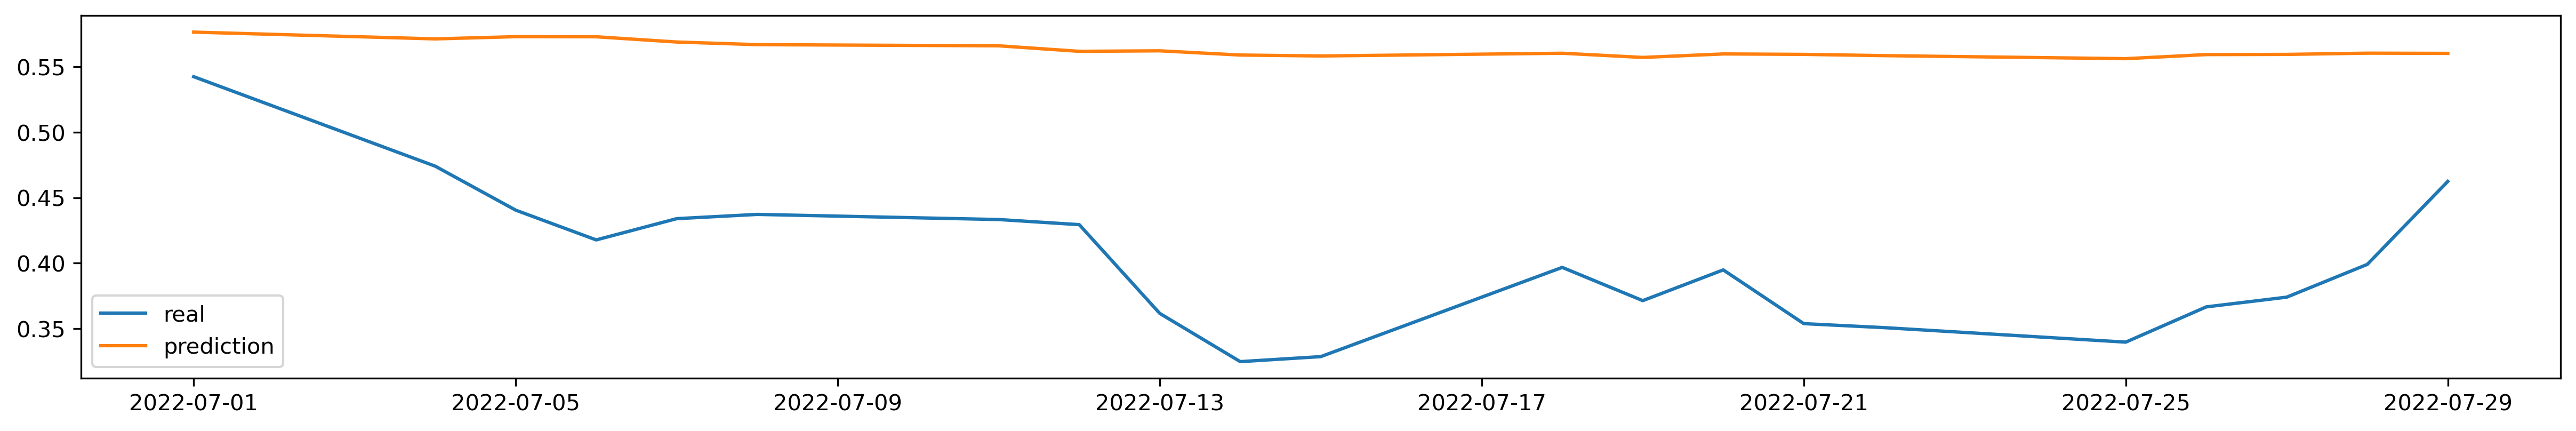

In [241]:
%%time
start = time.time()
print('Validation dataset July')
print('Train:\t',train_data_03.loc["FCPOc3"]["y"].index.min(),'~',train_data_03.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_03.loc["FCPOc3"]["y"].index.min(),'~',test_data_03.loc["FCPOc3"]["y"].index.max())
print(len(test_data_03.loc["FCPOc3"]["y"]))

val03_model_path = "model/autogluon-FCPOc3-t1-val03({}-{})".format(train_data_03.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_03.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
prediction_length = 30

print(val03_model_path)

predictor_val03 = TimeSeriesPredictor(
    path = val03_model_path,
    target ='y',
    prediction_length = prediction_length,
    eval_metric = "MAPE",
)
predictor_val03.fit(
    train_data=train_data_03,
    presets="good_quality"
)

predictor_val03_lb = predictor_val03.leaderboard(test_data_03, silent=True)
predictor_val03_lb.to_csv(os.path.join(os.getcwd(),
                                       val03_model_path,
                                       'leaderboard.csv')
                         )

predictions_val03_model01 = predictor_val03.predict(data = train_data_03,
                                                model = predictor_val03_lb['model'][0])

val03_result = pd.merge(test_data_03.loc['FCPOc3']['y'],  predictions_val03_model01.loc['FCPOc3']['mean'], 
                        left_index=True, right_index=True, 
                        how='left')
    
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val03_result['y'], label='real')
plt.plot(val03_result['mean'], label='prediction')
plt.legend()

val03_result.to_csv(os.path.join(os.getcwd(),val03_model_path,'prediction.csv'))
end = time.time()

In [242]:
print(f"good_quality 시간 : {end - start:.1f} sec")
print(f"good_quality 시간: {((end - start)/60):.1f} min")

good_quality 시간 : 1980.3 sec
good_quality 시간: 33.0 min


**val04 : June**

Learner random seed set to 0
presets is set to good_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: good_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 2,
                                'scheduler': 'local',
                                'searcher': 'random'},
 'hyperparameters': 'default_hpo',
 'prediction_length': 30,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 208500 rows, 101 items. Average time series length is 2064.3564356435645.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val04(20140702-20220531)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 30 time steps out to use as validation set.


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-05-31 00:00:00
Test:	 2022-06-01 00:00:00 ~ 2022-06-30 00:00:00
22
model/autogluon-FCPOc3-t1-val04(20140702-20220531)


AutoGluon will save models to model/autogluon-FCPOc3-t1-val04(20140702-20220531)/

Starting training. Start time is 2022-10-27 19:35:09
Models that will be trained: ['AutoETS', 'DeepAR', 'SimpleFeedForward', 'ARIMA', 'Transformer']
Hyperparameter tuning model: AutoETS. 


  0%|          | 0/2 [00:00<?, ?it/s]

endog must be strictly positive when usingmultiplicative error, trend or seasonal components.
Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 45, in model_trial
    time_limit=time_limit,
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 73, in fit_and_save_model
    train_data=train_data, val_data=val_data, time_limit=time_left, **fit_kwargs
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 188, in fit
    return super().fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 587, in fit
    out = self._fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/sktime/abstract_sktime.py", line 140, in _fit
    self._to_skt_dat

  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning DeepAR.
	-0.0951       = Validation score (-MAPE)
	991.93  s     = Total tuning time
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning SimpleFeedForward.
	-0.0855       = Validation score (-MAPE)
	247.88  s     = Total tuning time
Hyperparameter tuning model: ARIMA. 


  0%|          | 0/2 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 1 of 1 possible configs ran.
	Trained 1 models while tuning ARIMA.
	-0.0853       = Validation score (-MAPE)
	66.47   s     = Total tuning time
Hyperparameter tuning model: Transformer. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning Transformer.
	-0.0866       = Validation score (-MAPE)
	577.57  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.0833       = Validation score (-MAPE)
	91.22   s     = Training runtime
	23.53   s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS/T1', 'DeepAR/T1', 'DeepAR/T2', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'ARIMA/T1', 'Transformer/T1', 'Transformer/T2', 'WeightedEnsemble']
Total runtime: 2046.51 s
Best model: WeightedEnsemble
Best model score: -0.0833
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS/T1. An error occurred: division by zero
Cannot score with model DeepAR/T1. An error occurred: division by zero
Cannot score with model DeepAR/T2. An error occurred: division by zero
Cannot score with model SimpleFeedForward/T1. An error occurred: division by zero
Cannot score with mod

CPU times: user 3h 12min 3s, sys: 1min 29s, total: 3h 13min 32s
Wall time: 35min 52s


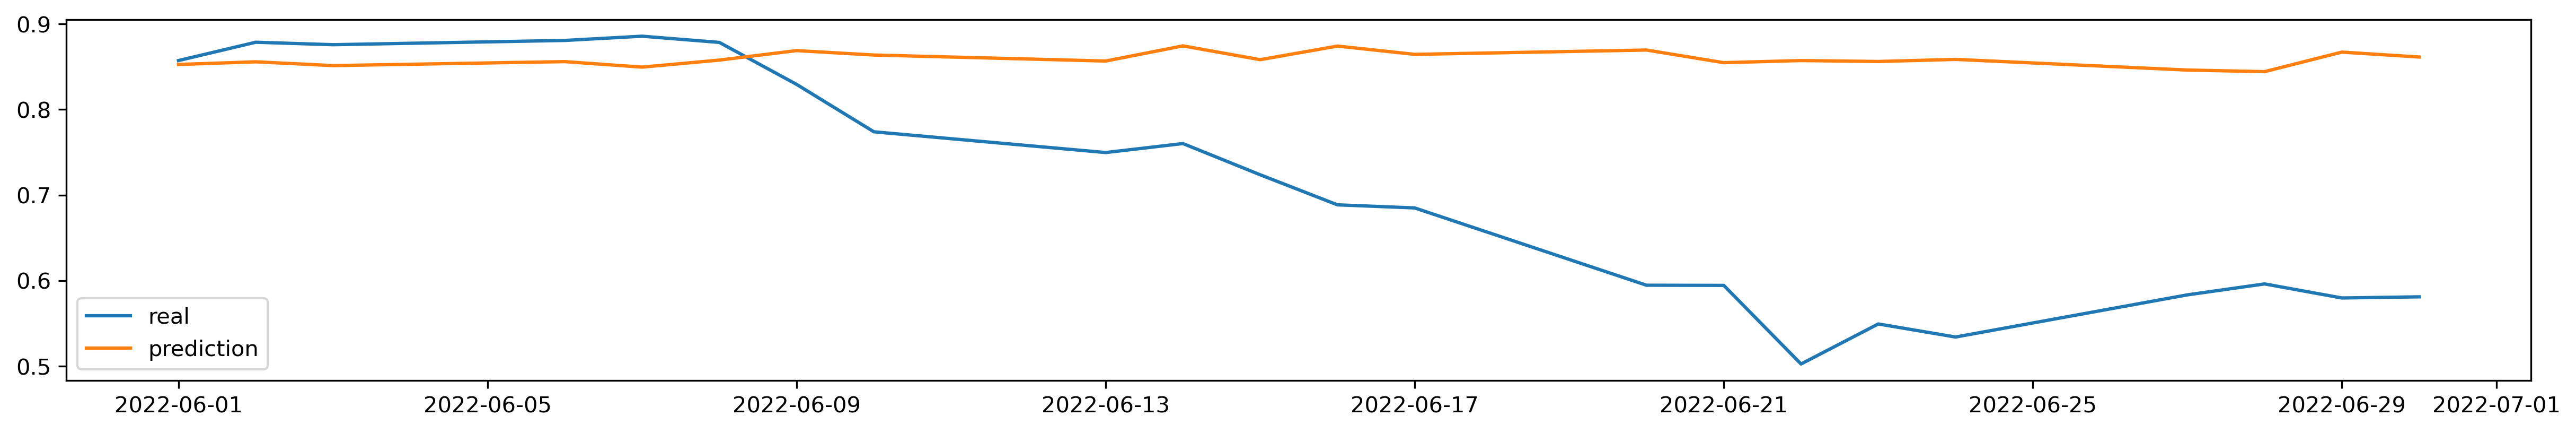

In [243]:
%%time
start = time.time()
print('Validation dataset June')
print('Train:\t',train_data_04.loc["FCPOc3"]["y"].index.min(),'~',train_data_04.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_04.loc["FCPOc3"]["y"].index.min(),'~',test_data_04.loc["FCPOc3"]["y"].index.max())
print(len(test_data_04.loc["FCPOc3"]["y"]))

val04_model_path = "model/autogluon-FCPOc3-t1-val04({}-{})".format(train_data_04.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_04.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
prediction_length = 30

print(val04_model_path)

predictor_val04 = TimeSeriesPredictor(
    path = val04_model_path,
    target ='y',
    prediction_length = prediction_length,
    eval_metric = "MAPE",
)
predictor_val04.fit(
    train_data=train_data_04,
    presets="good_quality"
)

predictor_val04_lb = predictor_val04.leaderboard(test_data_04, silent=True)
predictor_val04_lb.to_csv(os.path.join(os.getcwd(),
                                       val04_model_path,
                                       'leaderboard.csv')
                         )

predictions_val04_model01 = predictor_val04.predict(data = train_data_04,
                                                model = predictor_val04_lb['model'][0])

val04_result = pd.merge(test_data_04.loc['FCPOc3']['y'],  predictions_val04_model01.loc['FCPOc3']['mean'], 
                        left_index=True, right_index=True, 
                        how='left')
    
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val04_result['y'], label='real')
plt.plot(val04_result['mean'], label='prediction')
plt.legend()

val04_result.to_csv(os.path.join(os.getcwd(),val04_model_path,'prediction.csv'))
end = time.time()

In [244]:
print(f"good_quality 시간 : {end - start:.1f} sec")
print(f"good_quality 시간: {((end - start)/60):.1f} min")

good_quality 시간 : 2152.5 sec
good_quality 시간: 35.9 min


**val05: May**

Learner random seed set to 0
presets is set to good_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: good_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 2,
                                'scheduler': 'local',
                                'searcher': 'random'},
 'hyperparameters': 'default_hpo',
 'prediction_length': 30,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 206278 rows, 101 items. Average time series length is 2042.3564356435643.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val05(20140702-20220429)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 30 time steps out to use as validation set.


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-04-29 00:00:00
Test:	 2022-05-02 00:00:00 ~ 2022-05-31 00:00:00
22
model/autogluon-FCPOc3-t1-val05(20140702-20220429)


AutoGluon will save models to model/autogluon-FCPOc3-t1-val05(20140702-20220429)/

Starting training. Start time is 2022-10-27 20:11:02
Models that will be trained: ['AutoETS', 'DeepAR', 'SimpleFeedForward', 'ARIMA', 'Transformer']
Hyperparameter tuning model: AutoETS. 


  0%|          | 0/2 [00:00<?, ?it/s]

endog must be strictly positive when usingmultiplicative error, trend or seasonal components.
Traceback (most recent call last):
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 45, in model_trial
    time_limit=time_limit,
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/model_trial.py", line 73, in fit_and_save_model
    train_data=train_data, val_data=val_data, time_limit=time_left, **fit_kwargs
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 188, in fit
    return super().fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/core/models/abstract/abstract_model.py", line 587, in fit
    out = self._fit(**kwargs)
  File "/home/ec2-user/.local/lib/python3.7/site-packages/autogluon/timeseries/models/sktime/abstract_sktime.py", line 140, in _fit
    self._to_skt_dat

  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning DeepAR.
	-0.0789       = Validation score (-MAPE)
	1050.84 s     = Total tuning time
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).
Early stopping based on learning rate scheduler callback (min_lr was reached).


	Trained 2 models while tuning SimpleFeedForward.
	-0.0718       = Validation score (-MAPE)
	218.87  s     = Total tuning time
Hyperparameter tuning model: ARIMA. 


  0%|          | 0/2 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 1 of 1 possible configs ran.
	Trained 1 models while tuning ARIMA.
	-0.0804       = Validation score (-MAPE)
	68.05   s     = Total tuning time
Hyperparameter tuning model: Transformer. 


  0%|          | 0/2 [00:00<?, ?it/s]

	Trained 2 models while tuning Transformer.
	-0.0757       = Validation score (-MAPE)
	602.98  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.0686       = Validation score (-MAPE)
	91.04   s     = Training runtime
	6.00    s     = Validation (prediction) runtime
Training complete. Models trained: ['AutoETS/T1', 'DeepAR/T1', 'DeepAR/T2', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'ARIMA/T1', 'Transformer/T1', 'Transformer/T2', 'WeightedEnsemble']
Total runtime: 2101.94 s
Best model: WeightedEnsemble
Best model score: -0.0686
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS/T1. An error occurred: division by zero
Cannot score with model DeepAR/T1. An error occurred: division by zero
Cannot score with model DeepAR/T2. An error occurred: division by zero
Cannot score with model SimpleFeedForward/T1. An error occurred: division by zero
Cannot score with mod

CPU times: user 3h 16min 50s, sys: 1min 2s, total: 3h 17min 53s
Wall time: 35min 8s


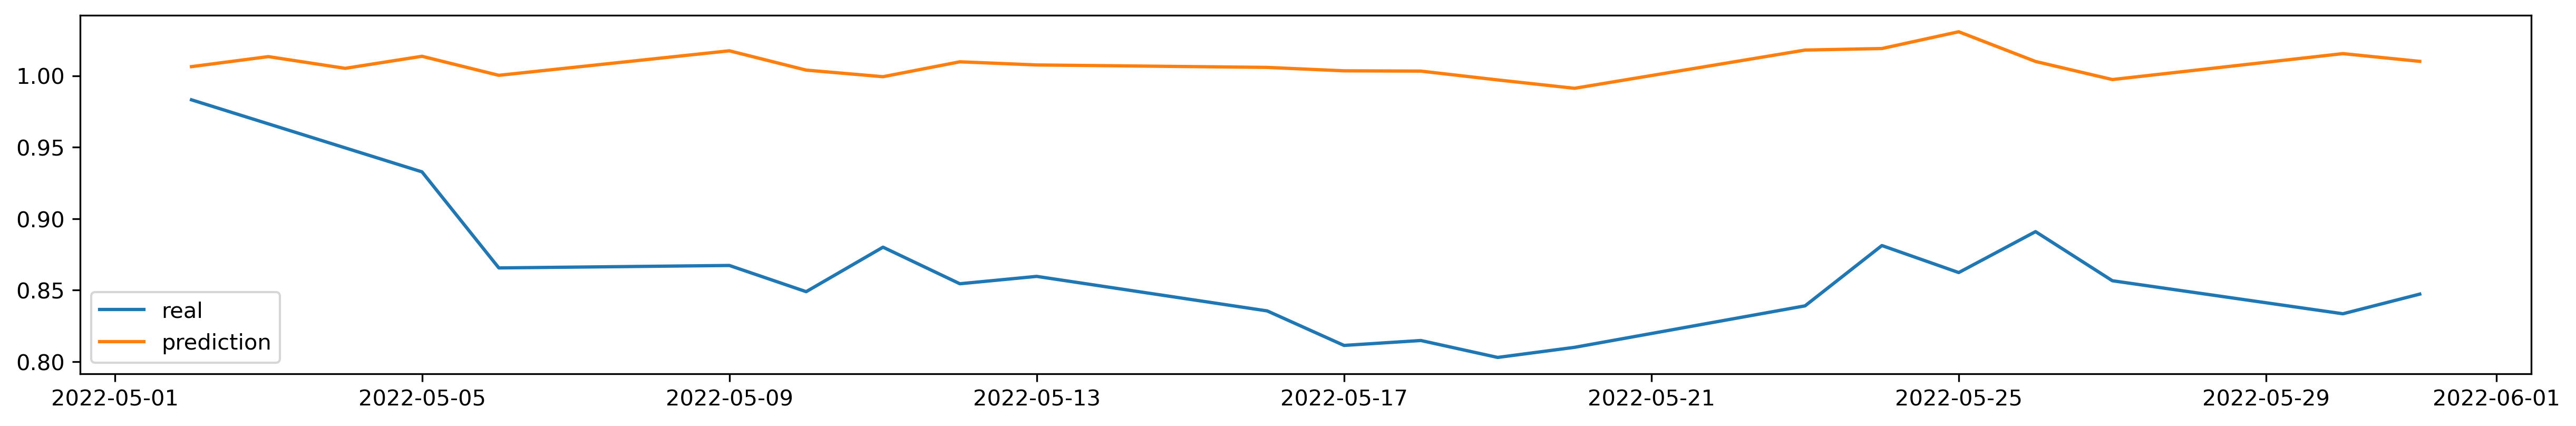

In [245]:
%%time
start = time.time()
print('Validation dataset May')
print('Train:\t',train_data_05.loc["FCPOc3"]["y"].index.min(),'~',train_data_05.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_05.loc["FCPOc3"]["y"].index.min(),'~',test_data_05.loc["FCPOc3"]["y"].index.max())
print(len(test_data_05.loc["FCPOc3"]["y"]))

val05_model_path = "model/autogluon-FCPOc3-t1-val05({}-{})".format(train_data_05.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_05.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
prediction_length = 30

print(val05_model_path)

predictor_val05 = TimeSeriesPredictor(
    path = val05_model_path,
    target ='y',
    prediction_length = prediction_length,
    eval_metric = "MAPE",
)
predictor_val05.fit(
    train_data=train_data_05,
    presets="good_quality"
)

predictor_val05_lb = predictor_val05.leaderboard(test_data_05, silent=True)
predictor_val05_lb.to_csv(os.path.join(os.getcwd(),
                                       val05_model_path,
                                       'leaderboard.csv')
                         )

predictions_val05_model01 = predictor_val05.predict(data = train_data_05,
                                                model = predictor_val05_lb['model'][0])

val05_result = pd.merge(test_data_05.loc['FCPOc3']['y'],  predictions_val05_model01.loc['FCPOc3']['mean'], 
                        left_index=True, right_index=True, 
                        how='left')
    
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val05_result['y'], label='real')
plt.plot(val05_result['mean'], label='prediction')
plt.legend()

val05_result.to_csv(os.path.join(os.getcwd(),val05_model_path,'prediction.csv'))
end = time.time()

In [246]:
print(f"good_quality 시간 : {end - start:.1f} sec")
print(f"good_quality 시간: {((end - start)/60):.1f} min")

good_quality 시간 : 2108.5 sec
good_quality 시간: 35.1 min


In [295]:
%%time
start = time.time()

import os
from tqdm import tqdm

def upload_folder_to_s3(s3_client, s3bucket, input_dir, s3_path):
    pbar = tqdm(os.walk(input_dir))
    for path, subdirs, files in pbar:
        for file in files:
            dest_path = path.replace(input_dir, "").replace(os.sep, '/')
            s3_file = f'{s3_path}/{dest_path}/{file}'.replace('//', '/')
            local_file = os.path.join(path, file)
            s3_client.upload_file(local_file, s3bucket, s3_file)
            pbar.set_description(f'Uploaded {local_file} to {s3_file}')
    print(f"Successfully uploaded {input_dir} to S3 {s3_path}")
    
s3_client = boto3.client('s3', aws_access_key_id=ACCESS_KEY_ID, aws_secret_access_key=ACCESS_SECRET_KEY)
upload_folder_to_s3(s3_client, BUCKET_NAME_USECASE, os.path.join(os.getcwd(),'model'), S3_PATH_TRAIN)
end = time.time()

Uploaded /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-PalmOil-(20140702-20220930)/utils/data/val.pkl to trained-model/autogluon-PalmOil-(20140702-20220930)/utils/data/val.pkl: : 13it [00:02,  5.07it/s]                                                                                     

Successfully uploaded /home/ec2-user/SageMaker/palm-oil-price-forecast/model to S3 trained-model
CPU times: user 1.66 s, sys: 954 ms, total: 2.61 s
Wall time: 2.57 s


In [249]:
print(f"5개 실험들 옮기는 시간 : {end - start:.1f} sec")
print(f"5개 실험들 옮기는 시간: {((end - start)/60):.1f} min")

5개 실험들 옮기는 시간 : 46.3 sec
5개 실험들 옮기는 시간: 0.8 min


## 2) 마지막! 스크립트화 하자
 위 (1)~(3)을 SKLearn Estimator로 스크립트화한다

In [136]:
preprocessed_training_data

's3://palm-oil-price-forecast/golden-data/2022/11/02'

In [137]:
preprocessed_test_data

's3://palm-oil-price-forecast/golden-data/2022/11/02'

### (1) Customizing 유동님 Github to 광진스 
- golden-data/에 포함

**SageMaker Training**
- autogluon 있는지 체크
    - 없으면 pip install
- 그리고 저장 장소를 output를 제대로 빼자

**SageMaker  Processing**
- autogluon 있는지 체크
    - 없으면 pip install
- 그리고 저장 장소를 output를 제대로 빼자

In [172]:
%%writefile code/train.py

import os
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import joblib # from sklearn.externals import joblib
import argparse
from dateutil.relativedelta import *

from datetime import datetime as dt
if __name__ == "__main__":
    # Data, model, and output directories
    print('start training code')
    parser = argparse.ArgumentParser()
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    # parser.add_argument('--mode', type=str)
    # parser.add_argument('--item', type=str)
    # parser.add_argument('--target', type=str)
    # parser.add_argument('--scaler', type=str, default = os.path.join(os.environ.get('SM_CHANNEL_TRAIN'),
                                                                     # 'scaler-files'))
    args, _ = parser.parse_known_args()
    
    print("Received arguments {}".format(args))
    
    print("Reading input data")    
    df_train= pd.read_csv(os.path.join(args.train,
                                       'train.csv'))
    df_test = pd.read_csv(os.path.join(args.test,
                                       'test.csv'))    
    
    print("Convert TimeSeriesDataFrame")
    df_train.loc[:, "ds"] = pd.to_datetime(df_train.loc[:, "ds"])
    df_test.loc[:, "ds"] = pd.to_datetime(df_test.loc[:, "ds"])
    train_data = TimeSeriesDataFrame.from_data_frame(
        df_train,
        id_column="ric",
        timestamp_column="ds",
    )
    test_data = TimeSeriesDataFrame.from_data_frame(
        df_test,
        id_column="ric",
        timestamp_column="ds",
    )
    
    print("Show the range of date for training and test")
    
    # print('Item:\t',args.item)
    # print('Target:\t',args.target)
    # print('Train:\t',train_data.loc[args.item][args.target].index.min(),'~',train_data.loc[args.item][args.target].index.max())
    # print('Test:\t',test_data.loc[args.item][args.target].index.min(),'~',test_data.loc[args.item][args.target].index.max())
    # print('The number of test data:',len(test_data.loc[args.item][args.target]))
    print('Train:\t',train_data.loc['FCPOc3']['y'].index.min(),'~',train_data.loc['FCPOc3']['y'].index.max())
    print('Test:\t',test_data.loc['FCPOc3']['y'].index.min(),'~',test_data.loc['FCPOc3']['y'].index.max())
    print('The number of test data:',len(test_data.loc['FCPOc3']['y']))
    
    print("Training AutoGluon Model")

    model_path = "{}/autogluon-PalmOil-({}-{})".format('s3://palm-oil-price-forecast/trained-model/2022/11/05/model',#args.model_dir,
                                                       # train_data.loc[args.item][args.target].index.min().strftime('%Y%m%d'),
                                                       # train_data.loc[args.item][args.target].index.max().strftime('%Y%m%d')
                                                       train_data.loc['FCPOc3']['y'].index.min().strftime('%Y%m%d'),
                                                       train_data.loc['FCPOc3']['y'].index.max().strftime('%Y%m%d')
                                                      )
    print("Saving model to {}".format(model_path))
    predictor = TimeSeriesPredictor(
        path = model_path,
        # target = args.target,
        # prediction_length = len(test_data.loc[args.item][args.target]),
        target = 'y',
        prediction_length = len(test_data.loc['FCPOc3']['y']),
        eval_metric = "MAPE",
    )
    predictor.fit(
        train_data = train_data,
        # presets = args.mode
        presets = 'low_quality'
    )
    
    print("Saving Results of Modeling to {}".format(args.output_data_dir))
    
    # 원래라면 Validation dataset이 input으로 들어와서 leaderboard와 prediction을 해야한다.
    # 근데, 여기서는 아니다. 이번 사이클에서는 test data까지 모두 산출한다음에 넣는것으로 진행하자.
    predictor_leaderboard = predictor.leaderboard(test_data,
                                                  silent=True)
    predictor_leaderboard.to_csv(os.path.join(args.output_data_dir,
                                              'leaderboard.csv'))
    
    KST = dt.today() + relativedelta(hours=9)



Overwriting code/train.py


train.py 트레이닝 스크립트는 트레이닝 데이터를 사용하여 logistic regression 모델을 만들고, 다음 디렉토리에 /opt/ml/model 모델을 저장합니다. Amazon SageMaker 는 tar 파일을 만들고다름과 같은 이름으로 model.tar.gz S3 에 업로드 합니다.

만들어진 train.py 스트립트를 사용하여 모델을 트레이닝 합니다.

#### SKLearn 사용

In [70]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

role = get_execution_role()
sklearn = SKLearn(
    entry_point="train.py",
    source_dir="./code",
    framework_version = "1.0-1",
    role = role,
    instance_type = "ml.m5.xlarge",
    instance_count = 1
)

In [89]:
model_s3_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                   S3_PATH_TRAIN,
                                   KST.strftime('%Y/%m/%d'),#%d'),##############
                                   'model/',
                                  )

output_s3_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                   S3_PATH_TRAIN,
                                   KST.strftime('%Y/%m/%d'),#%d'),##############
                                   'output/',
                                  )

In [72]:
print(preprocessed_training_data)
print(preprocessed_test_data)
print(model_s3_uri)
print(output_s3_uri)

s3://palm-oil-price-forecast/golden-data/2022/11/05
s3://palm-oil-price-forecast/golden-data/2022/11/05
s3://palm-oil-price-forecast/trained-model/2022/11/05/model
s3://palm-oil-price-forecast/trained-model/2022/11/05/output


In [73]:
print(S3_PATH_TRAIN + '/' + KST.strftime('%Y/%m/%d') + '/'+'model/')

trained-model/2022/11/05/model/


Parameter 입력 부분은 아래 Repository를 참고하자

https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md#sm_training_env

- Received arguments Namespace(
- item=None,
- mode=None,
- model_dir='/opt/ml/model',
- output_data_dir='/opt/ml/output/data',
- scaler='/opt/ml/input/data/train/scaler-files',
- target=None,
- test='/opt/ml/input/data/test',
- train='/opt/ml/input/data/train')


In [87]:
output_s3_uri

's3://palm-oil-price-forecast/trained-model/2022/11/05/output'

In [173]:
%%time
s3_client.put_object(Bucket = BUCKET_NAME_USECASE,
                     Body='',
                     Key = (S3_PATH_TRAIN + '/' + KST.strftime('%Y/%m/%d') + '/'+'model/'))#############################
s3_client.put_object(Bucket = BUCKET_NAME_USECASE,
                     Body='',
                     Key = (S3_PATH_TRAIN + '/' + KST.strftime('%Y/%m/%d') + '/'+'output/'))#####################

start = time.time()
sklearn.fit({
    # "output_data_dir" : output_s3_uri, # UnexpectedStatusException: Error for Training job sagemaker-scikit-learn-2022-11-05-06-53-30-905: Failed. Reason: ClientError: Data download failed:Failed to download data. S3 key: s3://palm-oil-price-forecast/trained-model/2022/11/05/model matched no files on s3
    # "model_dir" : model_s3_uri, # UnexpectedStatusException: Error for Training job sagemaker-scikit-learn-2022-11-05-06-53-30-905: Failed. Reason: ClientError: Data download failed:Failed to download data. S3 key: s3://palm-oil-price-forecast/trained-model/2022/11/05/model matched no files on s3
    "train" : preprocessed_training_data,
    "test" : preprocessed_test_data,
    # "mode" : 'low_quality', #ValueError: URI input low_quality must be a valid S3 or FILE URI: must start with "s3://" or "file://"
    # "item" : 'FCPOc3',
    # "target" : "y",
    # "scaler" : os.path.join(preprocessed_training_data,
    #                         "scaler-files"),
    
})

end = time.time()

2022-11-05 08:31:17 Starting - Starting the training job...
2022-11-05 08:31:40 Starting - Preparing the instances for trainingProfilerReport-1667637076: InProgress
.........
2022-11-05 08:33:13 Downloading - Downloading input data
2022-11-05 08:33:13 Training - Training image download completed. Training in progress..2022-11-05 08:33:14,830 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-05 08:33:14,833 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-05 08:33:14,842 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-05 08:33:14,998 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [92]:
print(f"학습 시간 : {end - start:.1f} sec")
print(f"학습 시간: {((end - start)/60):.1f} min")

학습 시간 : 496.6 sec
학습 시간: 8.3 min


\[2022년 11월 05일 기준\]   
Model Training 시간 : **527.4 sec(8.8min)**   
\[2022년 11월 05일 2차 기준\]   
Model Training 시간 : **496.6 sec(8.3min)**

In [93]:
training_job_description = sklearn.jobs[-1].describe()
training_job_description

{'TrainingJobName': 'sagemaker-scikit-learn-2022-11-05-07-04-06-433',
 'TrainingJobArn': 'arn:aws:sagemaker:ap-northeast-2:276114397529:training-job/sagemaker-scikit-learn-2022-11-05-07-04-06-433',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"sagemaker-scikit-learn-2022-11-05-07-04-06-433"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"ap-northeast-2"',
  'sagemaker_submit_directory': '"s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '366743142698.dkr.ecr.ap-northeast-2.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': False},
 

In [94]:
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)
output_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/output.tar.gz",
)
print(model_data_s3_uri)
print(output_data_s3_uri)

s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/model.tar.gz
s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/output.tar.gz


#### AugoGluon Container 사용
참조: https://docs.aws.amazon.com/sagemaker/latest/dg/ecr-ap-northeast-2.html

In [51]:
from sagemaker import image_uris
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

ag_container = image_uris.retrieve(
    "autogluon",
    region=region,
    version="0.4",
    py_version="py38",
    image_scope="training",
    instance_type = "ml.m5.xlarge",
)
print(ag_container)

763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/autogluon-training:0.4-cpu-py38


In [63]:
KST = dt.today() + relativedelta(hours=9)

s3_output_location='s3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE,
                                          S3_PATH_TRAIN,
                                          KST.strftime('%Y/%m/%d'),
                                          'model')
print(s3_output_location)

s3://palm-oil-price-forecast/trained-model/2022/11/05/model


In [58]:
print(sm_session)
print(role)
print(S3_PATH_GOLDEN)

arn:aws:iam::276114397529:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
golden-data


In [64]:
ag_xgb_model = sagemaker.estimator.Estimator(
    image_uri = ag_container,
    role = role,
    instance_count = 1,
    instance_type='ml.m5.2xlarge',
    volume_size = 5,
    output_path = s3_output_location,
    sagemaker_session = sm_session,
)

In [65]:
from sagemaker.session import TrainingInput

train_input = TrainingInput("s3://{}/{}/{}/{}".format(BUCKET_NAME_USECASE,
                                                      S3_PATH_GOLDEN,
                                                      KST.strftime('%Y/%m/%d'),
                                                      "train.csv"),
                            content_type="csv")
test_input = TrainingInput("s3://{}/{}/{}/{}".format(BUCKET_NAME_USECASE,
                                                     S3_PATH_GOLDEN,
                                                    KST.strftime('%Y/%m/%d'),
                                                    "test.csv"),
                            content_type="csv")

In [66]:
ag_xgb_model.fit({"train" : train_input,
                  "validation" : test_input},
                 wait=True)

2022-11-05 06:04:35 Starting - Starting the training job...
2022-11-05 06:04:59 Starting - Preparing the instances for trainingProfilerReport-1667628274: InProgress
.........
2022-11-05 06:06:19 Downloading - Downloading input data...
2022-11-05 06:06:59 Training - Training image download completed. Training in progress.2022-11-05 06:06:56,228 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-11-05 06:06:56,230 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-05 06:06:56,237 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': '', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.m5.2xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"],"instance_group_name":"homogeneousClu

UnexpectedStatusException: Error for Training job autogluon-training-2022-11-05-06-04-34-941: Failed. Reason: AlgorithmError: Framework Error: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sagemaker_training/trainer.py", line 87, in train
    entrypoint()
  File "/usr/local/lib/python3.8/dist-packages/sagemaker_mxnet_container/training.py", line 93, in main
    train(environment.Environment())
  File "/usr/local/lib/python3.8/dist-packages/sagemaker_mxnet_container/training.py", line 85, in train
    entry_point.run(uri=env.module_dir,
  File "/usr/local/lib/python3.8/dist-packages/sagemaker_training/entry_point.py", line 93, in run
    install(name=user_entry_point, path=environment.code_dir, capture_error=capture_error)
  File "/usr/local/lib/python3.8/dist-packages/sagemaker_training/entry_point.py", line 118, in install
    entry_point_type = _entry_point_type.get(path, name)
  File "/usr/local/lib/python3.8/dist-packages/sagemaker_training/_entry_point_type.py", line 43, in get
    if name.endswith(".sh"):
AttributeError: 'NoneType' object has no attribute 'endswith'

'NoneTy

# 3. SageMaker Model 검증
- S3 버킷에서 데이터 가지고 옴
- tar.gz 파일 해제
- MAPE 가장 높은거 토대로 model 가지고 옴

## 1) Notebook에서 테스트

In [84]:
from io import StringIO, BytesIO
import joblib

### (1) Leaderboard, model 데이터 가지고 오기

In [97]:
import tarfile

In [150]:
model_uri_file_path

'sagemaker-scikit-learn-2022-11-05-06-35-18-274/output/model.tar.gz'

In [134]:
model_uri_aws_path = model_data_s3_uri.split('//')[1]
model_uri_bucket = model_uri_aws_path.rsplit('/')[0]
model_uri_file_path = '/'.join(model_uri_aws_path.rsplit('/')[1:])

output_uri_aws_path = output_data_s3_uri.split('//')[1]
output_uri_bucket = output_uri_aws_path.rsplit('/')[0]
output_uri_file_path = '/'.join(output_uri_aws_path.rsplit('/')[1:])

In [140]:
leaderboard_obj = s3_client.get_object(Bucket = output_uri_bucket,
                                       Key = output_uri_file_path)
wholefile = leaderboard_obj['Body'].read()
fileobj = BytesIO(wholefile)
tar = tarfile.open(fileobj=fileobj)
leaderboard = pd.read_csv(tar.extractfile(member=tar.getmember(name = "leaderboard.csv")),
                         index_col=0)

In [137]:
model_obj = s3_client.get_object(Bucket = model_uri_bucket,
                                 Key = model_uri_file_path)
with tarfile.open(fileobj=model_obj['Body'], mode='r|gz') as file:
    file.extractall('./model')

In [141]:
leaderboard = leaderboard.sort_values(by = ['score_val', 'score_test'],
                                      ascending = False)
leaderboard.head()

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,NaN,-0.108585,NaN,2.050789,57.586957,6
3,DeepAR,NaN,-0.110053,NaN,2.050789,9.976756,3
2,SimpleFeedForward,NaN,-0.118833,NaN,0.664573,3.648567,2
4,AutoETS,NaN,-0.130147,NaN,7.015197,16.411729,1
1,Transformer,NaN,-0.138737,NaN,3.153895,7.326900,5


In [176]:
leaderboard[leaderboard['score_val'] > -0.11]

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,NaN,-0.108585,NaN,2.050789,57.586957,6


In [146]:
# leaderboard.iloc[0,0]


'DeepAR'

### (2) Model Registry에 등록 시키기

In [148]:
os.getcwd()

'/home/ec2-user/SageMaker/palm-oil-price-forecast'

In [152]:
import tarfile

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

model_pkl_dir = "{}/{}/autogluon-PalmOil-(20140702-20220930)/models/{}/model.pkl".format(os.getcwd(),
                                                                                   'model',
                                                                                   leaderboard.iloc[1,0])
                                                                                   
                                                                                      
                                                                                      
make_tarfile('{}.tar.gz'.format(leaderboard.iloc[1,0]),
             model_pkl_dir)


In [299]:
os.getcwd() palm-oil-price-forecast/model.tar.gz

'/home/ec2-user/SageMaker/palm-oil-price-forecast'

In [300]:
local_file = '/home/ec2-user/SageMaker/palm-oil-price-forecast/model.tar.gz'
s3bucket = 'palm-oil-price-forecast'
s3_file = 'trained-model/autogluon-PalmOil-(20140702-20220930)/model.tar.gz'
s3_client.upload_file(local_file,
                      s3bucket,
                      s3_file)

In [314]:
train_data_01

high       low      open         y
item_id timestamp                                         
BOPLKL  2014-07-02  0.761510  0.773238  0.768765  0.770750
        2014-07-03  0.755680  0.779194  0.768765  0.770750
        2014-07-04  0.755680  0.779194  0.768765  0.764870
        2014-07-07  0.755680  0.779194  0.762834  0.764870
        2014-07-08  0.755680  0.779194  0.762834  0.770750
...                      ...       ...       ...       ...
Wc3     2022-08-25  0.439938  0.439791  0.434771  0.442451
        2022-08-26  0.430638  0.437035  0.404725  0.460392
        2022-08-29  0.468354  0.449160  0.427324  0.501794
        2022-08-30  0.465513  0.473684  0.462506  0.476953
        2022-08-31  0.458280  0.462386  0.441705  0.489373

[215166 rows x 4 columns]

In [99]:
import pickle

In [154]:
model_pkl_dir

'/home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-PalmOil-(20140702-20220930)/models/DeepAR/model.pkl'

In [153]:
loaded_model = pickle.load(open(model_pkl_dir, 'rb'))
print(loaded_model)

DeepAR


In [164]:
type(loaded_model)

autogluon.timeseries.models.gluonts.models.DeepARModel

In [166]:
test_data

high       low      open         y
item_id timestamp                                         
BOc1    2022-10-03  0.630642  0.633881  0.618437  0.638470
        2022-10-04  0.654792  0.677319  0.662088  0.665142
        2022-10-05  0.657057  0.659479  0.666819  0.671087
        2022-10-06  0.664906  0.668942  0.667277  0.680994
        2022-10-07  0.683774  0.710673  0.693987  0.687243
...                      ...       ...       ...       ...
Wc3     2022-10-31  0.532679  0.534858  0.519004  0.560033
        2022-11-01  0.542495  0.550289  0.520544  0.581838
        2022-11-02  0.541462  0.518325  0.539548  0.525255
        2022-11-03  0.487988  0.507578  0.486903  0.519735
        2022-11-04  0.494188  0.514191  0.484335  0.528015

[2522 rows x 4 columns]

In [ ]:
test = loaded_trainer.predict(data = test_data,
                              model = leaderboard['model'][0])

# prediction_result = pd.merge(test_data.loc['FCPOc3']['y'],
#                              prediction_ag_model.loc['FCPOc3']['mean'],
#                              left_index = True,
#                              right_index = True,
#                              how = 'left')

## 2) 스크립트화 하자!

- run 옵션들: https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor

In [ ]:
s3_client.upload_file(local_file, s3bucket, s3_file)


In [351]:
image_uri

'763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/autogluon-training:0.4-cpu-py38'

In [353]:
image_uri = image_uris.retrieve(
    "autogluon",
    region=region,
    version="0.4",
    py_version="py38",
    image_scope="inference",
    instance_type = "ml.m5.xlarge",
)

In [355]:
image_uri

'763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/autogluon-inference:0.4-cpu-py38'

In [195]:
%%writefile code/validate.py

import glob
import os
import pandas as pd
import time
from datetime import datetime as dt
import argparse
import json
import boto3
from io import StringIO, BytesIO
import joblib
import sys
import subprocess
import tarfile


def get_secret():
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    secret_name = "prod/sagemaker"
    region_name = "ap-northeast-2"
    
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId='prod/sagemaker',
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException': # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException': # An error occurred on the server side.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException': # You provided an invalid value for a parameter.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException': # You provided a parameter value that is not valid for the current state of the resource.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException': # We can't find the resource that you asked for.
            raise e
    else:
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return secret
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return decoded_binary_secret
        
if __name__=='__main__':
    
    keychain = json.loads(get_secret())
    ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
    ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

    BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
    S3_PATH_STAGE = keychain['S3_PATH_STAGE']
    S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
    S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
    S3_PATH_log = keychain['S3_PATH_LOG']
    boto3_session = boto3.Session(ACCESS_KEY_ID,
                                  ACCESS_SECRET_KEY)

    region = boto3_session.region_name

    s3_resource = boto3_session.resource('s3')
    bucket = s3_resource.Bucket(BUCKET_NAME_USECASE)
    s3_client = boto3_session.client('s3')   

    sm_client = boto3.client('sagemaker',
                             aws_access_key_id = ACCESS_KEY_ID,
                             aws_secret_access_key = ACCESS_SECRET_KEY,
                             region_name = 'ap-northeast-2')
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path',
                        type = str,
                        help = 'train할때 나온 model.tar.gz을 가지고 온다.')

    args, _ = parser.parse_known_args()
    print("Received arguments {}".format(args))
    # 라이브러리 다운로드
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'fsspec'])
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 's3fs','--upgrade'])

# 아래 코드는 나중에 Batch Transform할때만 쓸거다 
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'autogluon'])
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'mxnet==1.9'])

    
#     from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

#     df_test = pd.read_csv(os.path.join(args.test,'test.csv'))
#     df_test.loc[:, "ds"] = pd.to_datetime(df_test.loc[:, "ds"])
#     test_data = TimeSeriesDataFrame.from_data_frame(
#         df_test,
#         id_column="ric",
#         timestamp_column="ds",
#     )
    
    # 리더보드 읽기
    # leaderboard_obj = s3_client.get_object(Bucket = args.bucket,#'sagemaker-ap-northeast-2-276114397529',
    #    
    # Key = args.output_path #'sagemaker-scikit-learn-2022-11-02-09-05-35-503/output/output.tar.gz')
    output_fname = '/opt/ml/processing/outputs/output.tar.gz'
    if output_fname.endswith("tar.gz"):
        tar = tarfile.open(output_fname, "r:gz")
        tar.extractall('/opt/ml/processing/outputs/leaderboard')
        tar.close()
    elif output_fname.endswith("tar"):
        tar = tarfile.open(output_fname, "r:")
        tar.extractall('/opt/ml/processing/outputs/leaderboard')
        tar.close()
    
    leaderboard = pd.read_csv('/opt/ml/processing/outputs/leaderboard/leaderboard.csv')

    # wholefile = leaderboard_obj['Body'].read()
    # fileobj = BytesIO(wholefile)
    # tar = tarfile.open(fileobj=fileobj)
    # leaderboard = pd.read_csv(tar.extractfile(member=tar.getmember(name="leaderboard.csv")))
    
    # 모델 데이터 읽기
    # model_obj = s3_client.get_object(Bucket = args.bucket,#'sagemaker-ap-northeast-2-276114397529',
    #                                  Key = args.model_path)'sagemaker-scikit-learn-2022-11-02-09-05-35-503/output/model.tar.gz')
    # with tarfile.open(fileobj=model_obj['Body'], mode='r|gz') as file:
    #     file.extractall('/opt/ml/model')
    # print(os.listdir())
    model_package_group_name = 'palm-oil-price-forecast'

    model_fname = '/opt/ml/processing/models/model.tar.gz'
    if len(leaderboard[leaderboard['score_val'] > -0.11]) > 0:
        # model_url = "s3://palm-oil-price-forecast/trained-model/autogluon-PalmOil-(20140702-20220930)/model.tar.gz"

        modelpackage_inference_specification =  {
            "InferenceSpecification": {
                "Containers": [
                    {
                        "Image": '763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/autogluon-inference:0.4-cpu-py38',
                        "ModelDataUrl": args.model_path
                    }
                ],
                "SupportedContentTypes": [ "text/csv" ],
                "SupportedResponseMIMETypes": [ "text/csv" ],
            }
        }


        create_model_package_input_dict = {
            "ModelPackageGroupName" : model_package_group_name,
            "ModelPackageDescription" : "AutoGluon" ,
            "ModelApprovalStatus" : "PendingManualApproval"
        }
        create_model_package_input_dict.update(modelpackage_inference_specification)


        create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
        model_package_arn = create_model_package_response["ModelPackageArn"]
        print('ModelPackage Version ARN : {}'.format(model_package_arn))
    
       # 아래 코드는 나중에 Batch Transform할때만 쓸거다 
    # loaded_trainer = pickle.load(open("/opt/ml/model/autogluon-PalmOil-(20140702-20220930)/models/trainer.pkl", 'rb'))
    # prediction_result = loaded_trainer.predict(data = test_data,
    #                                            model = leaderboard['model'][0])
    # prediction_result = pd.merge(test_data.loc['FCPOc3']['y'],
    #                              prediction_result.loc['FCPOc3']['mean'],
    #                              left_index = True,
    #                              right_index = True,
    #                              how = 'left')
    # predictor_leaderboard.to_csv(os.path.join(args.output_data_dir,
    #                                           'leaderboard.csv'))
    

Overwriting code/validate.py


In [184]:
print(model_data_s3_uri)
print(output_data_s3_uri)

s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/model.tar.gz
s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/output.tar.gz


In [185]:
model_data_s3_uri

's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/model.tar.gz'

In [194]:
preprocessed_test_data

's3://palm-oil-price-forecast/golden-data/2022/11/05'

In [196]:
%%time
from sagemaker.processing import ProcessingInput, ProcessingOutput
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
import time
start = time.time()

# region = boto_session.region_name  
role = get_execution_role()
sklearn_processor = SKLearnProcessor(framework_version = "1.0-1",
                                     role = role,
                                     instance_type = "ml.m5.xlarge",
                                     instance_count = 1
                                    )
KST = dt.today() + relativedelta(hours=9)

s3_source_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                          S3_PATH_GOLDEN,
                                          KST.strftime('%Y/%m/%d'),##########################################%d로 바꿔줘야함.
                                          '{}.csv'.format('stage'),
                                         )
s3_destination_uri = 's3://{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                            'inference-data',
                                            KST.strftime('%Y/%m/%d')
                                           )
sklearn_processor.run(
    code = "code/validate.py",
    inputs = [
        ProcessingInput(
            source = model_data_s3_uri,
            # input_name = 'model_from_train',
            destination = "/opt/ml/processing/models/"),
        ProcessingInput(
            source = output_data_s3_uri,
            # input_name = 'output_from_train',
            destination = "/opt/ml/processing/outputs/")
    ],
    outputs = [
        ProcessingOutput(
            output_name = "validation_output",
            source = "/opt/ml/processing/output"),
    ],
    arguments=["--model_path", model_data_s3_uri],
    
    
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()
end = time.time()


Job Name:  sagemaker-scikit-learn-2022-11-06-02-44-23-443
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/model.tar.gz', 'LocalPath': '/opt/ml/processing/models/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/output.tar.gz', 'LocalPath': '/opt/ml/processing/outputs/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-06-02-44-23-443/input/code/validate.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3Data

In [197]:
print(f"Staging Data 시간 : {end - start:.1f} sec")
print(f"Staging Data 시간 : {((end - start)/60):.1f} min")

Staging Data 시간 : 282.5 sec
Staging Data 시간 : 4.7 min


\[2022년 11월 05일 기준\]   
Model Validation and Register a Model Version 시간 : **282.5 sec(4.7min)**

In [198]:
preprocessing_job_description

{'ProcessingInputs': [{'InputName': 'input-1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/model.tar.gz',
    'LocalPath': '/opt/ml/processing/models/',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'input-2',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-05-07-04-06-433/output/output.tar.gz',
    'LocalPath': '/opt/ml/processing/outputs/',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-11-06-02-44-23-443/input/code/validate.py',
    'LocalPath': '/opt/ml/processing/i

# 4. SageMaker Inference Prediction(for Batch Transform)
모델검증 후 
- 입력값 : Test data
    - 오늘 날짜의 Golden data 내 test.csv에서 가지고 와야하지 않을까?
- 사용모델 : Model Registry에 있는 것 중 최신의 model을 가지고 옴(Batch Transform을 위해서)
    - 
- 출력값 : Prediction value



In [199]:
from sagemaker import ModelPackage
from time import gmtime, strftime

model_package_arn = 'arn:aws:sagemaker:ap-northeast-2:276114397529:model-package/palm-oil-price-forecast/5'
model = ModelPackage(role = role, 
                     model_package_arn = model_package_arn, 
                     sagemaker_session = sm_session)
model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Invalid approval status "PendingManualApproval" for ModelPackage "arn:aws:sagemaker:ap-northeast-2:276114397529:model-package/palm-oil-price-forecast/5". Can only create a SageMaker Model for ModelPackages in Approved status.

In [202]:
from sagemaker import ModelPackage
from time import gmtime, strftime

model_package_arn = 'arn:aws:sagemaker:ap-northeast-2:276114397529:model-package/palm-oil-price-forecast/5'
model = ModelPackage(role = role, 
                     model_package_arn = model_package_arn, 
                     sagemaker_session = sm_session)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-----!

In [207]:
type(model)

sagemaker.model.ModelPackage

In [204]:
type(predictor)

NoneType

In [210]:
!pip install ag_model


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
ERROR: Could not find a version that satisfies the requirement ag_model (from versions: none)
ERROR: No matching distribution found for ag_model
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p37/bin/python -m pip install --upgrade pip' command.


In [208]:
import sagemaker

# Helper wrappers referred earlier
from ag_model import (
    # AutoGluonTraining,
    AutoGluonInferenceModel,
    # AutoGluonTabularPredictor,
)
from sagemaker import utils

ModuleNotFoundError: No module named 'ag_model'

In [ ]:
endpoint_name = sagemaker.utils.unique_name_from_base("sagemaker-autogluon-serving-trained-model")

model_data = sagemaker_session.upload_data(
    path=os.path.join(".", "model.tar.gz"), key_prefix=f"{endpoint_name}/models"
)